## Description

This does a simple 1D case where instead of using a NN, things are done analytically with pdfs or histograms, since the NN output can be predicted from that.

Explores the errors from the bootstrap method.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import time
from stopwatch import Stopwatch, profile

from IPython import display


### Parameters

In [2]:

##--- parameters describing the gen distribution
gen_mu0c = 0.0
gen_sigma0c = 1.0

gen_mu0t = 1.6
gen_sigma0t = 3

#gen_fc = 0.7
gen_fc = 1.0



##--- parameters for the true data, which are different
#nat_mu0c = 0.8
#nat_sigma0c = 0.8

nat_mu0c = 0.2
nat_sigma0c = 0.8

nat_mu0t = 1.5
nat_sigma0t = 3.5

#nat_fc = 0.5
nat_fc = 1.0





##--- parameters for an acceptance turn-on function

#acc_t = 9.5

acc_t = 0.5

acc_w = 6.0


##--- parameters for an experimental resolution function
#reso_sig = 1.5
#reso_delta = -0.2

reso_sig = 0.5
reso_delta = 0.0



##--- Toy sample parameters

#N_toy = 10**4
N_toy = 10**4

#N_toy_mc = 10*N_toy
N_toy_mc = 100*N_toy



iterations = 4


dummyval = -30

pdf_points = 40

n_hist_bins = pdf_points
#x_min = -15
#x_max = 15

x_min = -4
x_max = 4

In [3]:


x = np.linspace(x_min, x_max, pdf_points)

x_binwidth = (x_max-x_min)/(pdf_points-1)
x_bins = np.linspace( x_min-0.5*x_binwidth, x_max+0.5*x_binwidth, pdf_points+1)

xshift = np.linspace(x_min+0.5*x_binwidth, x_max+0.5*x_binwidth, pdf_points)


##-- mc, gen

pdf_gen0c = (gen_fc)*np.exp(-(x-gen_mu0c)*(x-gen_mu0c)/(2*gen_sigma0c*gen_sigma0c))/gen_sigma0c
pdf_gen0t = (1-gen_fc)*np.exp(-(x-gen_mu0t)*(x-gen_mu0t)/(2*gen_sigma0t*gen_sigma0t))/gen_sigma0t

pdf_gen0 = pdf_gen0c + pdf_gen0t



##-- nature, gen  (this is data with perfect resolution, which may be different from gen above)
pdf_nat0c = (nat_fc)*np.exp(-(x-nat_mu0c)*(x-nat_mu0c)/(2*nat_sigma0c*nat_sigma0c))/nat_sigma0c
pdf_nat0t = (1-nat_fc)*np.exp(-(x-nat_mu0t)*(x-nat_mu0t)/(2*nat_sigma0t*nat_sigma0t))/nat_sigma0t

pdf_nat0 = pdf_nat0c + pdf_nat0t






##-- an acceptance function
func_acc = 1./(1+np.exp(acc_w*(x-acc_t)))




#-- Note: Need to use xshift in pdf_reso in order for np.convolve to do the right thing.
#         Without it, the output has a 1/2 binwidth shift.

##-- a resolution function
#pdf_reso = np.exp(-(x-reso_delta)*(x-reso_delta)/(2*reso_sig*reso_sig))
pdf_reso = np.exp(-(xshift-reso_delta)*(xshift-reso_delta)/(2*reso_sig*reso_sig))
pdf_reso = pdf_reso / np.sum(pdf_reso)



##-- mc with resolution
pdf_sim = np.convolve(pdf_gen0, pdf_reso,'same')

##-- nature with resolution (this is the real data)
pdf_nat = np.convolve( pdf_nat0, pdf_reso, 'same')


##-- mc with resolution and acceptance
pdf_sim_acc = pdf_sim * func_acc

##-- data with resolution and acceptance
pdf_nat_acc = pdf_nat * func_acc


### Gen pdf from the sum of two components

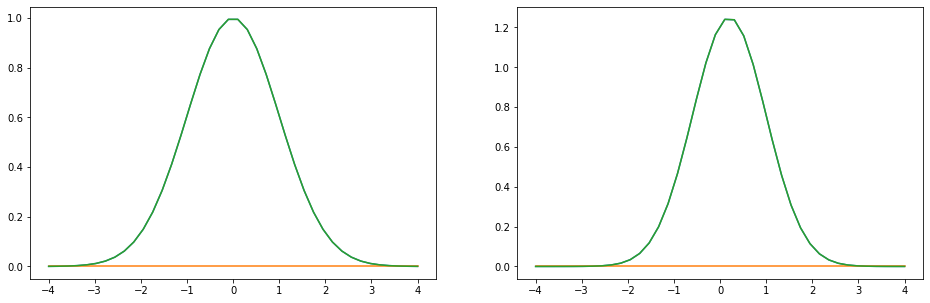

In [4]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(x,pdf_gen0c)
ax[0].plot(x,pdf_gen0t)
ax[0].plot(x,pdf_gen0)

ax[1].plot(x,pdf_nat0c)
ax[1].plot(x,pdf_nat0t)
ax[1].plot(x,pdf_nat0)

plt.show()

### Acceptance function and Resolution function

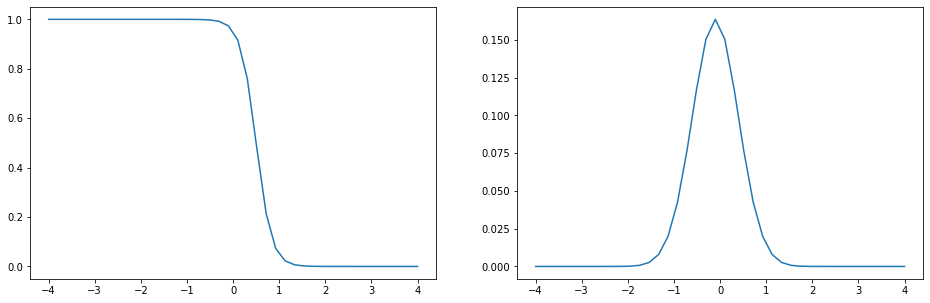

In [5]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(x,func_acc)

ax[1].plot(x,pdf_reso)

plt.show()

### A comparison of gen and sim, before acceptance

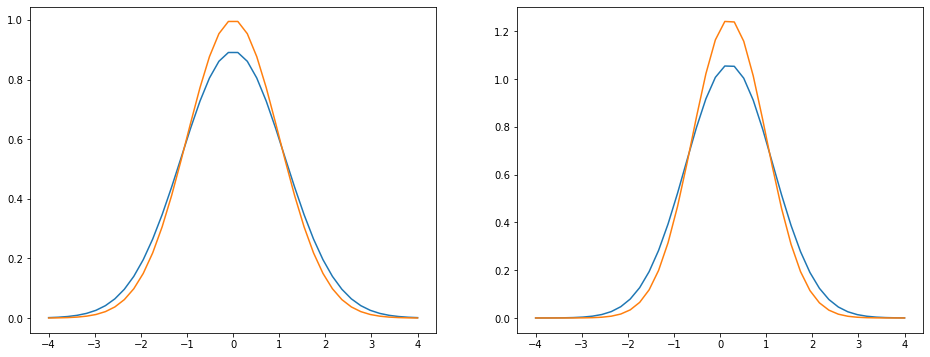

In [6]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(x,pdf_sim)
ax[0].plot(x,pdf_gen0)

ax[1].plot(x,pdf_nat)
ax[1].plot(x,pdf_nat0)

plt.show()


### compare gen with nature (perfect resolution on left finite resolution on right)

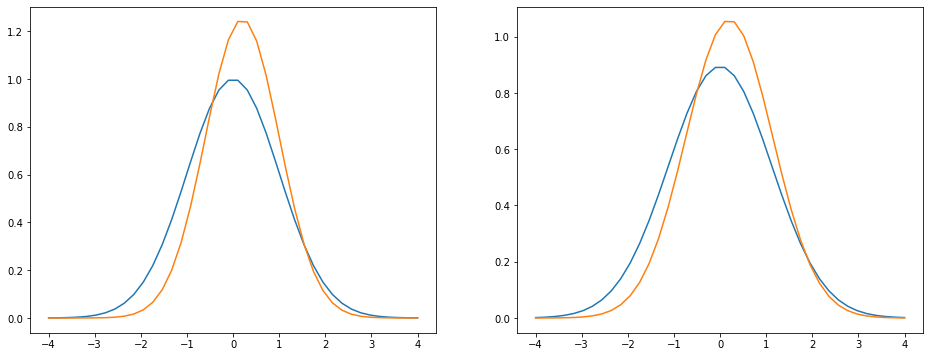

In [7]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(x,pdf_gen0)
ax[0].plot(x,pdf_nat0*(np.sum(pdf_gen0)/np.sum(pdf_nat0)))

ax[1].plot(x,pdf_sim)
ax[1].plot(x,pdf_nat*(np.sum(pdf_sim)/np.sum(pdf_nat)))


plt.show()

### Adding sim with acceptance to the comparison

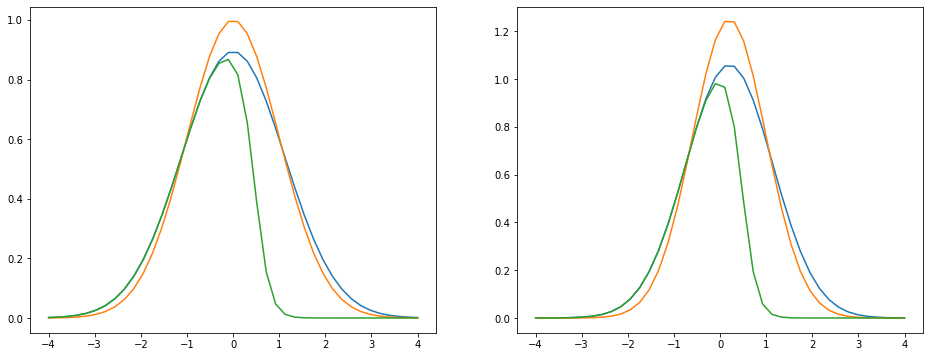

In [8]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(x,pdf_sim)
ax[0].plot(x,pdf_gen0)
ax[0].plot(x,pdf_sim_acc)

ax[1].plot(x,pdf_nat)
ax[1].plot(x,pdf_nat0)
ax[1].plot(x,pdf_nat_acc)

plt.show()

In [9]:
np.sum(pdf_nat0)

12.219806299866555

In [10]:
np.sum(pdf_nat_acc)

7.565576510417548

### Generate the toy MC

In [11]:
toy_gen0 = np.concatenate( [
    np.random.normal( gen_mu0c, gen_sigma0c, np.int32(np.rint(N_toy_mc*gen_fc)) ),
    np.random.normal( gen_mu0t, gen_sigma0t, np.int32(np.rint(N_toy_mc*(1.-gen_fc))) ) ]
)

toy_sim = np.array( toy_gen0 + np.random.normal( reso_delta, reso_sig, N_toy_mc) )

toy_acc_val_sim = 1./(1+np.exp(acc_w*(toy_sim-acc_t)))
toy_acc_sim_rndm = np.random.uniform(0,1,N_toy_mc)

toy_sim_acc = np.array(toy_sim)
toy_sim_acc[toy_acc_sim_rndm>toy_acc_val_sim] = dummyval




toy_nat0 = np.concatenate( [
    np.random.normal( nat_mu0c, nat_sigma0c, np.int32(np.rint(N_toy*nat_fc)) ),
    np.random.normal( nat_mu0t, nat_sigma0t, np.int32(np.rint(N_toy*(1.-nat_fc))) ) ]
)

toy_nat = np.array( toy_nat0 + np.random.normal( reso_delta, reso_sig, N_toy) )

toy_acc_val_nat = 1./(1+np.exp(acc_w*(toy_nat-acc_t)))
toy_acc_nat_rndm = np.random.uniform(0,1,N_toy)

toy_nat_acc = np.array(toy_nat)
toy_nat_acc[toy_acc_nat_rndm>toy_acc_val_nat] = dummyval




toy_nat0_100x = np.concatenate( [
    np.random.normal( nat_mu0c, nat_sigma0c, np.int32(np.rint(N_toy*100*nat_fc)) ),
    np.random.normal( nat_mu0t, nat_sigma0t, np.int32(np.rint(N_toy*100*(1.-nat_fc))) ) ]
)

weights_nat0_100x = 0.01 * np.ones( len(toy_nat0_100x) )


## Validation of gen and sim
Histograms should agree exactly with the pdf curves

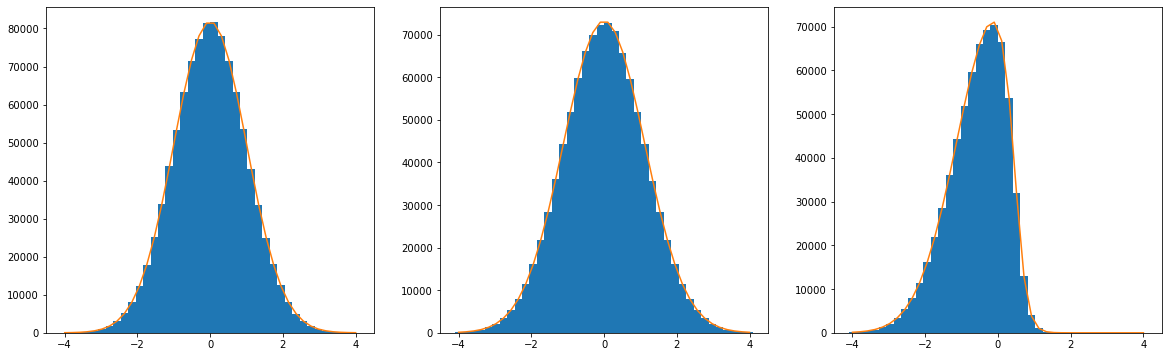

In [12]:
fig,ax = plt.subplots(1,3,figsize=(20,6))

ax[0].hist( toy_gen0, bins=x_bins)
ax[0].plot( x, pdf_gen0*(N_toy_mc/np.sum(pdf_gen0)) )

ax[1].hist( toy_sim, bins=x_bins)
ax[1].plot( x, pdf_sim*(N_toy_mc/np.sum(pdf_sim)) )

ax[2].hist( toy_sim_acc, bins=x_bins)
ax[2].plot( x, pdf_sim_acc*(N_toy_mc/np.sum(pdf_sim)) )

plt.show()

## Validation of the "data" or nature samples
Histograms should agree exactly with the pdf curves

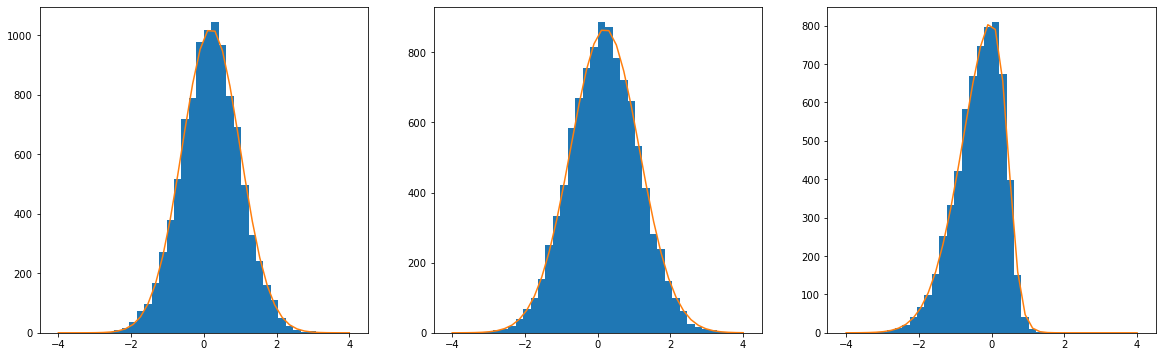

In [13]:
fig,ax = plt.subplots(1,3,figsize=(20,6))

ax[0].hist( toy_nat0, bins=x_bins)
ax[0].plot( x, pdf_nat0*(N_toy/np.sum(pdf_nat0)) )

h0_dat = ax[1].hist( toy_nat, bins=x_bins)
ax[1].plot( x, pdf_nat*(N_toy/np.sum(pdf_nat)) )

ha_dat = ax[2].hist( toy_nat_acc, bins=x_bins)
ax[2].plot( x, pdf_nat_acc*(N_toy/np.sum(pdf_nat)) )

plt.show()

In [14]:
np.sum(h0_dat[0])

9999.0

In [15]:
Nobs_total = np.sum(ha_dat[0])
print("Total number of observed events:  %.1f" % Nobs_total)

Total number of observed events:  6289.0


## Inspect the simulation and nature toy datasets in 2D (sim vs gen)

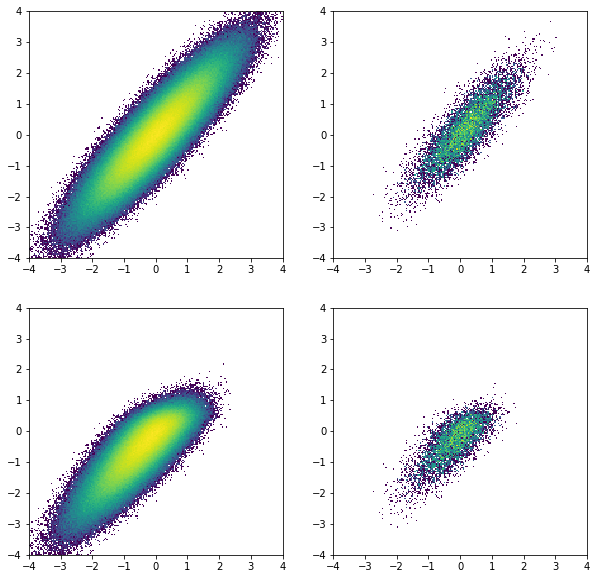

In [16]:
fig,ax = plt.subplots(2,2,figsize=(10,10))

ax[0][0].hist2d( toy_gen0, toy_sim, bins=200, norm=mpl.colors.LogNorm(), range=([x_min,x_max],[x_min,x_max]) )
ax[0][1].hist2d( toy_nat0, toy_nat, bins=200, norm=mpl.colors.LogNorm(), range=([x_min,x_max],[x_min,x_max]) )

ax[1][0].hist2d( toy_gen0, toy_sim_acc, bins=200, norm=mpl.colors.LogNorm(), range=([x_min,x_max],[x_min,x_max]) )
ax[1][1].hist2d( toy_nat0, toy_nat_acc, bins=200, norm=mpl.colors.LogNorm(), range=([x_min,x_max],[x_min,x_max]) )

plt.show()

## Each event has a sim bin index and a gen0 bin index

The **step 1** weight is a function of the sim value, so we need the sim histogram bin index for that.

The **step 2** weight is a function of the gen0 value, so we need the gen0 histogram bin index for that.

**Watch out!**  Digitize returns 0 for values below bins and len(x_bins)+1 for values above bins, so it returns 1 for values in the first bin.  If want to use this as an array index, need to shift by one!  

In [17]:
toy_sim_bin_indices = np.digitize( toy_sim, x_bins)

In [18]:
toy_sim_bin_indices = toy_sim_bin_indices - 1

In [19]:
toy_sim_bin_indices_safe = np.clip( toy_sim_bin_indices, 0, pdf_points-1 )

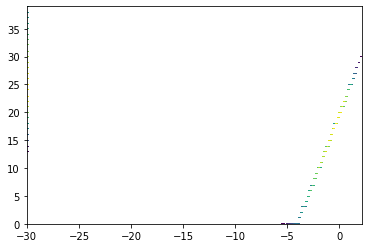

In [20]:
plt.hist2d( toy_sim_acc, toy_sim_bin_indices_safe, bins=200, norm=mpl.colors.LogNorm() )
plt.show()

In [21]:
toy_gen0_bin_indices = np.digitize( toy_gen0, x_bins)

In [22]:
toy_gen0_bin_indices = toy_gen0_bin_indices - 1

In [23]:
toy_gen0_bin_indices_safe = np.clip(toy_gen0_bin_indices, 0, pdf_points-1 )

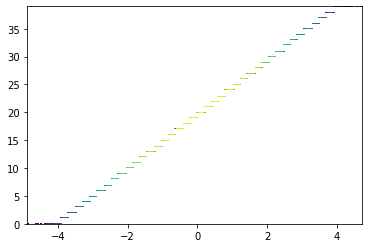

In [24]:
plt.hist2d( toy_gen0, toy_gen0_bin_indices_safe, bins=200, norm=mpl.colors.LogNorm() )
plt.show()

In [25]:
weights0_mc = np.ones( len(toy_sim) )
weights0_mc = (N_toy/N_toy_mc) * weights0_mc

In [26]:
weights0_mc

array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01])

## Collect things needed for calculating unfolding matrix M

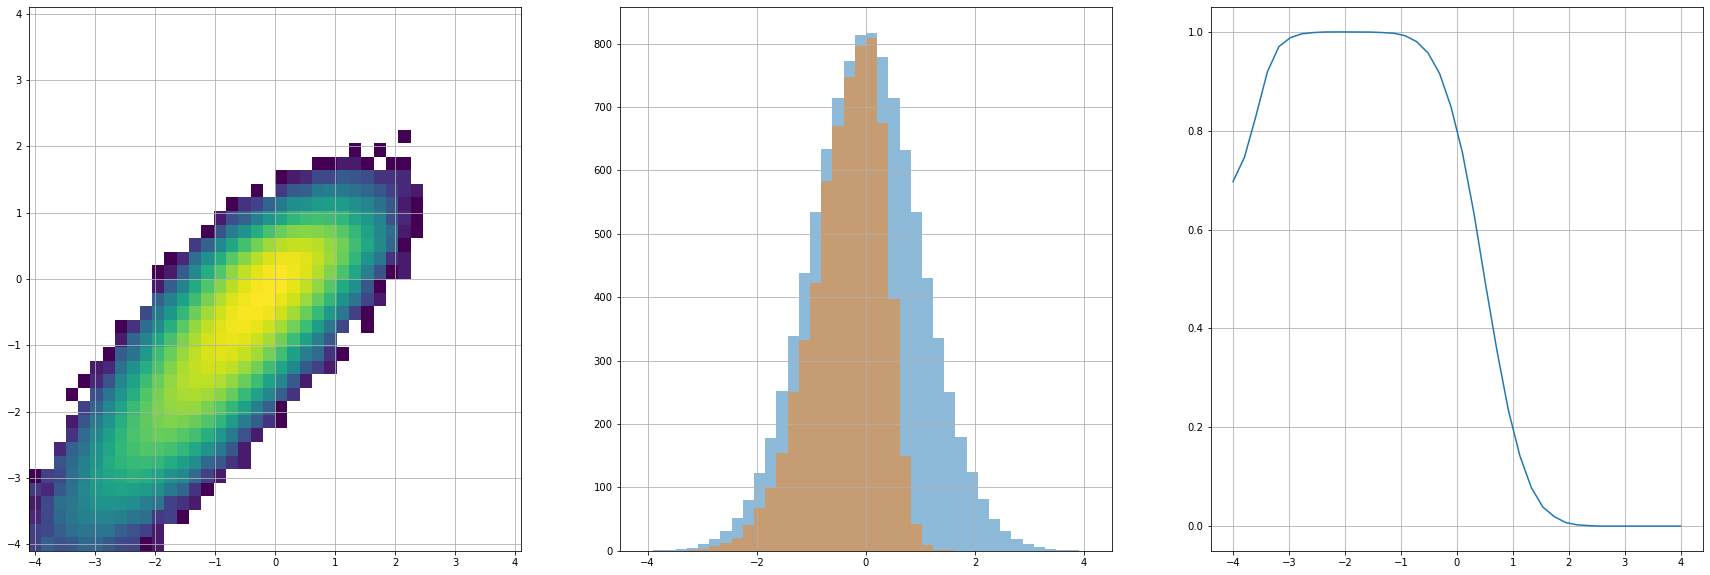

In [27]:

fig,ax = plt.subplots(1,3,figsize=(30,10))

mc_hist_2d_data = ax[0].hist2d( toy_gen0, toy_sim_acc, bins=(x_bins,x_bins), 
                               weights=weights0_mc, norm=mpl.colors.LogNorm() )
ax[0].grid(True)

mc_hist_gen0 = ax[1].hist( toy_gen0, bins=x_bins, weights=weights0_mc, alpha=0.5 )
hist_nat  = ax[1].hist( toy_nat_acc, bins=x_bins, alpha=0.5 ) 
ax[1].grid(True)

mc_hist_2d_bin_data = mc_hist_2d_data[0]
mc_hist_gen0_data = mc_hist_gen0[0]
hist_nat_data = hist_nat[0]

eff_gen = np.zeros(len(mc_hist_gen0_data))

for j in range(0,len(mc_hist_gen0_data)):
    this_sum = 0
    for i in range(0,len(mc_hist_gen0_data)):
        this_sum = this_sum + mc_hist_2d_bin_data[j][i]
    if mc_hist_gen0_data[j] > 0:
        eff_gen[j] = this_sum / mc_hist_gen0_data[j]
        
ax[2].plot( x, eff_gen)
ax[2].grid(True)

plt.show()

In [28]:

print("\n\n mc_hist_2d_bin_data[:,20]")
print(mc_hist_2d_bin_data[:,20])
print("\n\n mc_hist_2d_bin_data[20,:]")
print(mc_hist_2d_bin_data[20,:])
print(mc_hist_2d_bin_data[20,20])
print(mc_hist_2d_bin_data[20][20])



 mc_hist_2d_bin_data[:,20]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e-02 2.0000e-02
 1.5000e-01 8.5000e-01 3.5000e+00 1.0240e+01 2.5310e+01 5.1760e+01
 8.3070e+01 1.1129e+02 1.1989e+02 1.0506e+02 7.5610e+01 4.4330e+01
 2.1080e+01 8.2600e+00 2.7800e+00 5.8000e-01 1.1000e-01 1.0000e-02
 2.0000e-02 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]


 mc_hist_2d_bin_data[20,:]
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e-02 1.0000e-02 1.7000e-01
 7.7000e-01 2.4400e+00 7.1600e+00 1.6810e+01 3.6060e+01 6.3890e+01
 9.3100e+01 1.1768e+02 1.1989e+02 9.3880e+01 4.6730e+01 1.4640e+01
 2.7100e+00 4.7000e-01 5.0000e-02 1.0000e-02 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
119.89000000002443
119.89000000002443


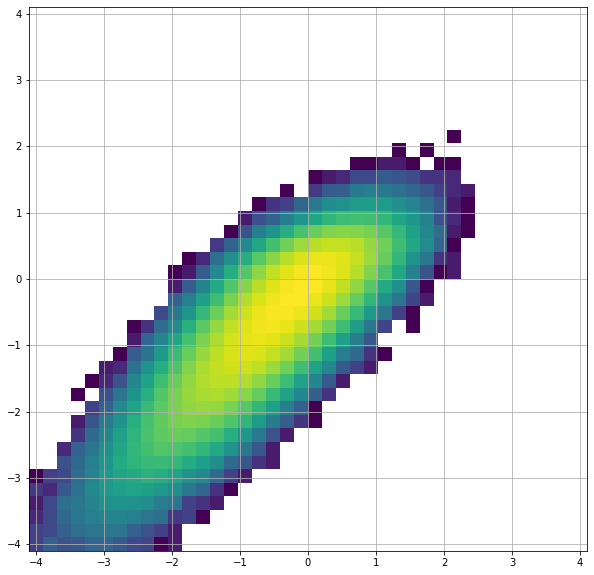

In [29]:

#swap_xy = np.zeros( shape = mc_hist_2d_bin_data.shape )
#for i in range(0, n_hist_bins) :
#    for j in range(0, n_hist_bins) :
#        swap_xy[i][j] = mc_hist_2d_bin_data[j][i]

swap_xy = np.swapaxes( mc_hist_2d_bin_data, 0, 1 )

fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.pcolormesh( x_bins, x_bins, swap_xy, norm=mpl.colors.LogNorm() )
ax.grid(True)

plt.show()

## Function for calculating the unfolding matrix M.  
See d'Agostini, 1995 paper, section 4.

In [30]:
def calc_unfolding_matrix( current_gen_estimate ) :
    
    #print("In top of calc_unfolding_matrix")
    #print( current_gen_estimate )
    #print( mc_hist_gen0_data )
    #print( mc_hist_2d_bin_data[20])
    
    M = np.zeros( shape=(n_hist_bins, n_hist_bins))
    
    for j in range( 0, n_hist_bins ):
        
        reweighted_mc_sum = 0
        
        for k in range( 0, n_hist_bins ):
            if mc_hist_gen0_data[k] > 0 :
                reweighted_mc_sum = reweighted_mc_sum + mc_hist_2d_bin_data[k,j] * current_gen_estimate[k] / mc_hist_gen0_data[k]
                #print( "k = %d : %.3f %.3f" % (k, mc_hist_2d_bin_data[k,j] * current_gen_estimate[k] / mc_hist_gen0_data[k], reweighted_mc_sum))
        
        #print( "Effect %d : reweighted_mc_sum = %.3f" % (j,reweighted_mc_sum ))
        for i in range( 0, n_hist_bins ) :
            
            if mc_hist_gen0_data[i] > 0 and eff_gen[i] * reweighted_mc_sum > 0 :
            
                M[i,j] = mc_hist_2d_bin_data[i,j] * ( current_gen_estimate[i] / mc_hist_gen0_data[i] ) / ( eff_gen[i] * reweighted_mc_sum )
                
        
    return M


In [31]:


def calc_covariance( M, n_observed ) :
    
    V = np.zeros( shape = M.shape )
    
    for k in range( 0, n_hist_bins ) :
        
        for l in range( 0, n_hist_bins ) :
            
            sum1 = 0
            
            for j in range( 0, n_hist_bins ) :
                
                sum1 = sum1 + M[k,j] * M[l,j] * n_observed[j] * ( 1 - n_observed[j] / N_toy )
                
            sum2 = 0
            
            for i in range( 0, n_hist_bins ) :
                
                for j in range( 0, n_hist_bins ) :
                    
                    if i != j :
                        
                        sum2 = sum2 + M[k,i] * M[l,j] * n_observed[i] * n_observed[j] / N_toy
                        
            V[k,l] = sum1 - sum2
                    
                
    return V
                    
                    
                    

# Analytic version of the unfolding

## Do the OmniFold iterations in a loop

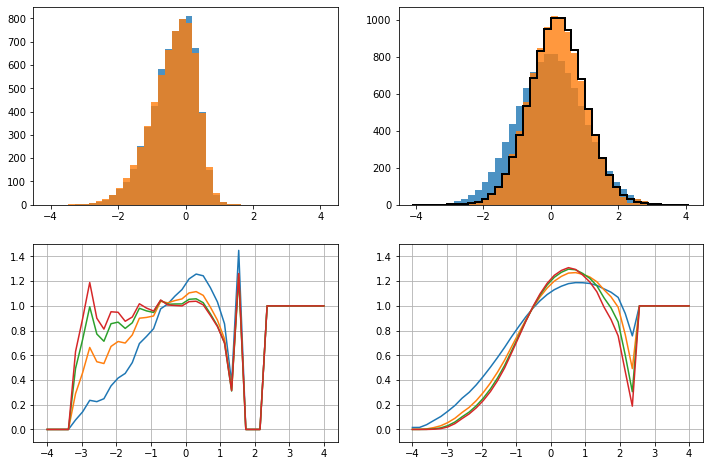




 All Done





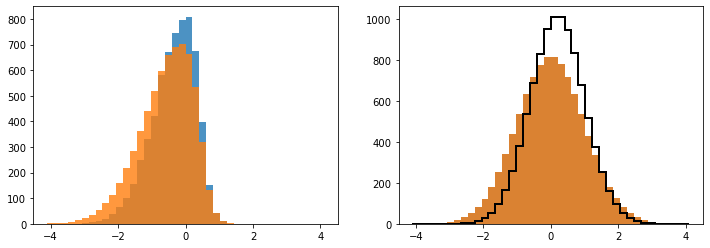

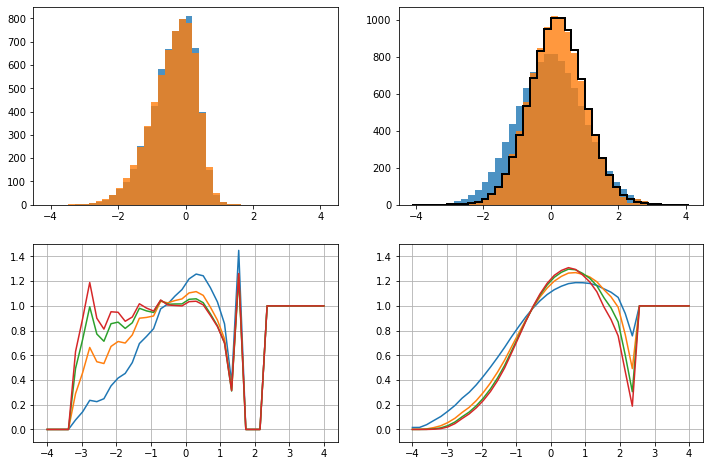

In [32]:

#do_smooth = True
do_smooth = False


iterations = 4

iter_predictions = np.zeros( shape=(iterations, n_hist_bins) )

pull_weights = np.ones( len(toy_sim) )
push_weights = np.ones( len(toy_gen0) )


fig,ax = plt.subplots(1,2,figsize=(12,4))



ax[0].cla()
#hist_nat = ax[0].hist( toy_nat, bins=x_bins, alpha=0.8 )
#hist_sim = ax[0].hist( toy_sim, bins=x_bins, alpha=0.8 )

hist_nat = ax[0].hist( toy_nat_acc, bins=x_bins, alpha=0.8 )
hist_sim = ax[0].hist( toy_sim_acc, bins=x_bins, weights=weights0_mc, alpha=0.8 )

ax[1].cla()
hist_genw = ax[1].hist( toy_gen0[pull_weights!=10], weights=weights0_mc, bins=x_bins, alpha=0.8)
hist_gen0 = ax[1].hist( toy_gen0[pull_weights!=10], weights=weights0_mc, bins=x_bins, alpha=0.8)
ax[1].hist( toy_nat0_100x, bins=x_bins, linewidth=2, 
            weights=weights_nat0_100x, density=False, color='black', histtype = 'step')

display.display(plt.gcf())

print("\n\n Initialization.")




fig,ax = plt.subplots(2,2,figsize=(12,8))

for i in range(0,iterations) :
    
    print("\n\n ======== Iteration %d" % i )
    
    display.clear_output(wait =True)

    
    
    
    #-- step 1  ---------------------------------------------------------
    
    ax[0][0].cla()
    #-- this is with perfect acceptance
    #hist_nat = ax[0][0].hist( toy_nat, bins=x_bins, alpha=0.8 )
    #hist_sim = ax[0][0].hist( toy_sim, bins=x_bins, weights=push_weights, alpha=0.8 )
    
    #-- this is with finite acceptance
    hist_nat = ax[0][0].hist( toy_nat_acc, bins=x_bins, alpha=0.8 )
    hist_sim = ax[0][0].hist( toy_sim_acc, bins=x_bins, weights=push_weights*weights0_mc, alpha=0.8 )    
    
    hist_sim_safe = np.clip(hist_sim[0],1e-9,1e25)
    hist_nat_safe = np.clip(hist_nat[0],1e-9,1e25)
    
    weight_step1 = hist_nat_safe / hist_sim_safe
    
    weight_step1_clipped = np.clip(weight_step1, -10, 10)
    
    ax[1][0].plot(x, weight_step1_clipped)
    ax[1][0].grid(True)
    ax[1][0].set_ylim(-0.1,1.5)
    
    
    pull_weights = push_weights * weight_step1_clipped[ toy_sim_bin_indices_safe ]


    
    
    
    #-- reset weights for events that don't pass reco.
    
    #-- simplest possible way:  set them equal to 1.
    #     This way gives very biased results!
    #pull_weights[ toy_sim_acc==dummyval ] = 1
    
    
    #-- this is the way it's done in Ben's GaussianExample
    #     Using np.histogram because I don't need to see these, just need the data for the hist bins.
    alt_hist_w0 = np.histogram( toy_gen0[toy_sim_acc!=dummyval], bins=x_bins )
    alt_hist_wp = np.histogram( toy_gen0[toy_sim_acc!=dummyval], bins=x_bins, weights=pull_weights[toy_sim_acc!=dummyval] )    

    alt_hist_w0_safe = np.clip(alt_hist_w0[0],1e-9,1e25)
    alt_hist_wp_safe = np.clip(alt_hist_wp[0],1e-9,1e25)

    alt_weight_step1 = alt_hist_wp_safe / alt_hist_w0_safe

    alt_weight_step1_clipped = np.clip(alt_weight_step1, -10, 10)
    
    pull_weights[ toy_sim_acc==dummyval ] = alt_weight_step1_clipped[ toy_gen0_bin_indices_safe[ toy_sim_acc==dummyval ] ]
    
    
    
    
    
    
    
    
    
    
    
    
    #-- step 2  ---------------------------------------------------------

    ax[0][1].cla()
    hist_gen0 = ax[0][1].hist( toy_gen0[pull_weights!=10], weights=weights0_mc[pull_weights!=10], bins=x_bins, alpha=0.8)
    hist_genw = ax[0][1].hist( toy_gen0[pull_weights!=10], weights=pull_weights[pull_weights!=10]*weights0_mc[pull_weights!=10], bins=x_bins, alpha=0.8)

    truth_distribution = ax[0][1].hist( toy_nat0_100x, bins=x_bins, linewidth=2, 
                  weights=weights_nat0_100x, density=False, color='black', histtype = 'step')
    

    hist_genw_binvals = hist_genw[0]
    
    if do_smooth:
        if ( i < (iterations-1) ):
            z = np.polyfit( x, hist_genw_binvals,15)
            p = np.poly1d(z)
            hist_genw_binvals = p(x)
    
    
    hist_genw_safe = np.clip(hist_genw_binvals,1e-9,1e25)
    hist_gen0_safe = np.clip(hist_gen0[0],1e-9,1e25)
    
    weight_step2 = hist_genw_safe / hist_gen0_safe
    
    weight_step2_clipped = np.clip(weight_step2, -10, 10)
    
    ax[1][1].plot(x, weight_step2_clipped)
    ax[1][1].grid(True)
    ax[1][1].set_ylim(-0.1,1.5)
    
    push_weights = weight_step2_clipped[ toy_gen0_bin_indices_safe ]
    
    #-- reset weights for events that don't pass truth (fakes or not correct true process).
        

    prediction = np.histogram( toy_gen0[pull_weights!=10], bins=x_bins, 
                                    weights=push_weights[pull_weights!=10]*weights0_mc[pull_weights!=10] )


    M = calc_unfolding_matrix( hist_genw[0] )
    
    V = calc_covariance( M, hist_nat[0] )
            
            
    
    iter_predictions[i,:] = prediction[0]
    
    display.display(plt.gcf())
    

    
print("\n\n\n All Done\n\n\n")    

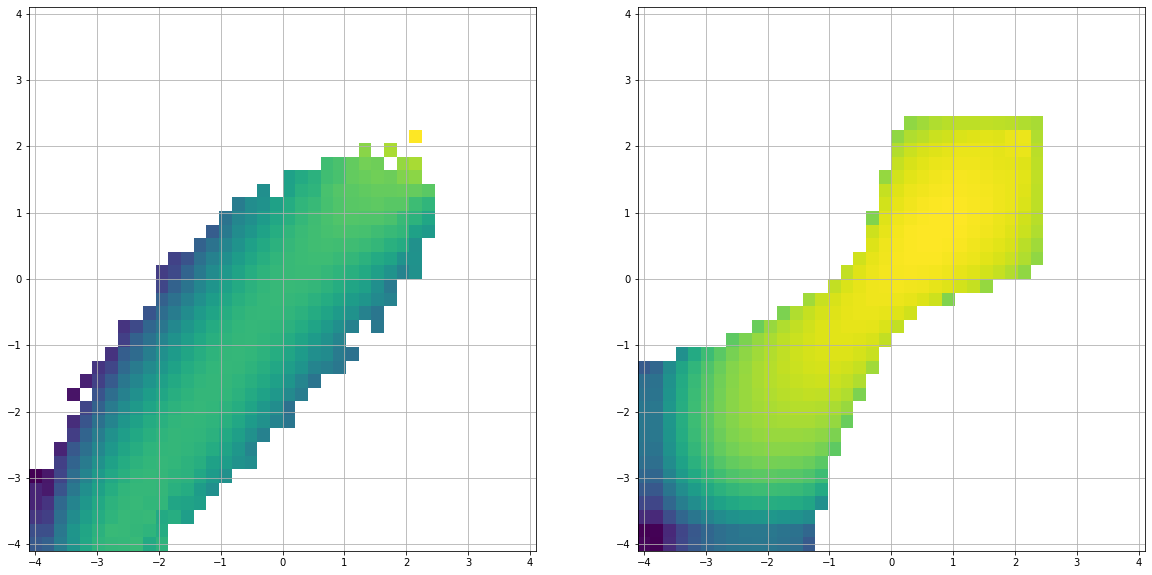

In [33]:
#swap_xy = np.zeros( shape = M.shape )
#for i in range(0, n_hist_bins) :
#    for j in range(0, n_hist_bins) :
#        swap_xy[i,j] = M[j,i]


swap_xy = np.swapaxes( M, 0, 1)
        
fig,ax = plt.subplots(1,2,figsize=(20,10))

ax[0].pcolormesh( x_bins, x_bins, swap_xy, norm=mpl.colors.LogNorm() )
ax[0].grid(True)

        
ax[1].pcolormesh( x_bins, x_bins, V, norm=mpl.colors.LogNorm() )
ax[1].grid(True)

plt.show()

In [34]:
correlation_matrix = np.zeros( shape=V.shape )

for i in range(0, n_hist_bins) :
    sigma_i = np.sqrt( V[i,i] )
    for j in range(0, n_hist_bins) :
        sigma_j = np.sqrt( V[j,j] )
        rho = 0
        if sigma_i > 0 and sigma_j > 0 :
            rho = V[i,j] / (sigma_i * sigma_j)
        correlation_matrix[i,j] = rho
        

        

In [35]:
np.max( correlation_matrix)

1.0000000000000002

In [36]:
np.min( correlation_matrix)

-0.30819903826942835

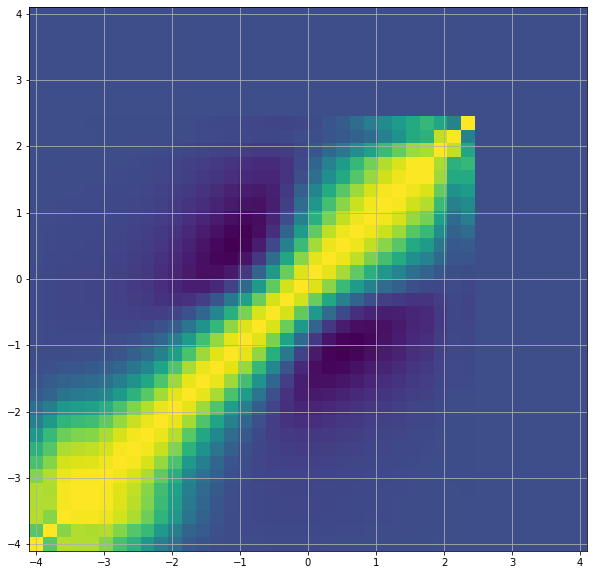

In [37]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.pcolormesh( x_bins, x_bins, correlation_matrix )
ax.grid(True)

plt.show()


In [38]:
pred_errs = np.zeros( n_hist_bins )
for j in range(0,n_hist_bins):
    pred_errs[j] = np.sqrt(V[j,j])
    print("  bin %3d :  N = %9.1f  +/-  %9.1f" % (j, prediction[0][j], np.sqrt(V[j,j])))

  bin   0 :  N =       0.0  +/-        0.0
  bin   1 :  N =       0.0  +/-        0.0
  bin   2 :  N =       0.0  +/-        0.0
  bin   3 :  N =       0.0  +/-        0.0
  bin   4 :  N =       0.0  +/-        0.0
  bin   5 :  N =       0.2  +/-        0.0
  bin   6 :  N =       0.9  +/-        0.1
  bin   7 :  N =       2.7  +/-        0.3
  bin   8 :  N =       6.5  +/-        0.6
  bin   9 :  N =      14.1  +/-        1.0
  bin  10 :  N =      28.7  +/-        1.5
  bin  11 :  N =      54.7  +/-        2.1
  bin  12 :  N =      99.2  +/-        2.9
  bin  13 :  N =     168.7  +/-        3.8
  bin  14 :  N =     273.0  +/-        4.9
  bin  15 :  N =     399.8  +/-        5.9
  bin  16 :  N =     555.0  +/-        6.7
  bin  17 :  N =     711.6  +/-        7.4
  bin  18 :  N =     848.6  +/-        8.1
  bin  19 :  N =     962.8  +/-        9.1
  bin  20 :  N =    1018.7  +/-       10.3
  bin  21 :  N =    1002.8  +/-       11.5
  bin  22 :  N =     935.4  +/-       12.6
  bin  23 :

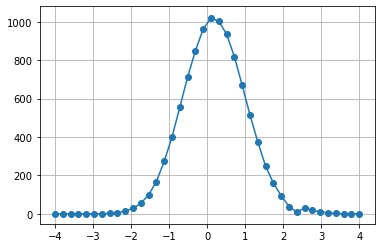

In [39]:
plot_data = plt.errorbar( x, prediction[0], yerr=pred_errs, fmt='-o')
plt.grid()
plt.show()

In [40]:
unfolded_dist = np.zeros( n_hist_bins )

for i in range(0, n_hist_bins) :
    
    for j in range(0, n_hist_bins) :
        
        unfolded_dist[i] = unfolded_dist[i] + M[i,j] * hist_nat_data[j]
        
        #print( "%d, %d :  %.3f * %.0f = %.3f" % (i,j, M[i,j], hist_nat_data[j], unfolded_dist[i]))

In [41]:
diff = unfolded_dist - prediction[0]

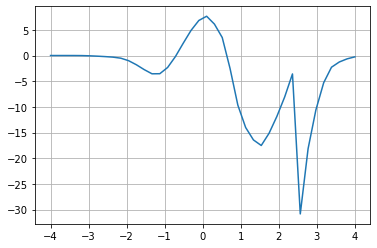

In [42]:
plt.plot(x,diff)
plt.grid(True)

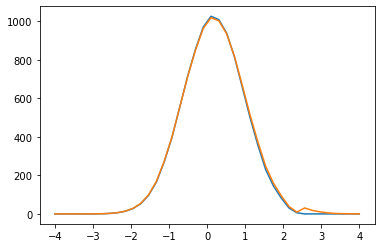

In [43]:
plt.plot(x,unfolded_dist)
plt.plot(x,prediction[0])

In [44]:
z = np.polyfit( x, prediction[0],15)

In [45]:
z

array([-1.27709701e-05, -2.13549057e-04,  9.34940554e-04,  1.35336770e-02,
       -3.01219752e-02, -3.56785657e-01,  5.54433535e-01,  5.11512930e+00,
       -6.24552517e+00, -4.37884660e+01,  4.24499270e+01,  2.29514620e+02,
       -1.59294033e+02, -7.02090649e+02,  2.55502026e+02,  9.93495812e+02])

In [46]:
p = np.poly1d(z)

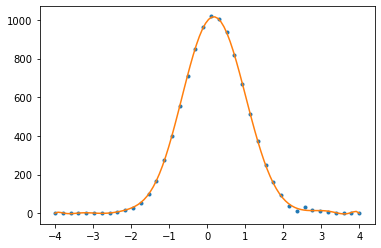

In [47]:
xp = np.linspace(-4,4,100)

plt.plot( x, prediction[0], '.', xp, p(xp), '-')
plt.show()

In [48]:
diffs = p(x) - prediction[0]

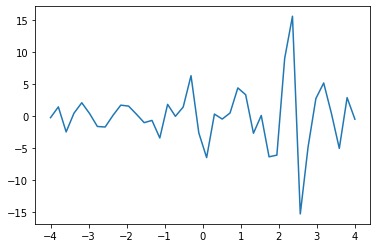

In [49]:
plt.plot( x, diffs)
plt.show()

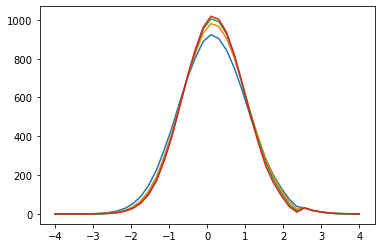

In [50]:
plt.plot( x, iter_predictions[0])
plt.plot( x, iter_predictions[1])
plt.plot( x, iter_predictions[2])
plt.plot( x, iter_predictions[3])
plt.show()

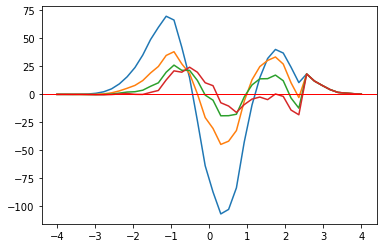

In [51]:
for i in range(0,iterations):
    plt.plot( x, iter_predictions[i]-truth_distribution[0])

plt.axhline( 0, color='red', lw=1)
plt.show()

## Bootstrapping section

Will try to evaluate statistical uncertainties using the bootstrap method.  The method is to make ~100 datasets using sampling with replacement and run the procedure on each of the 100.  The mean and spread of the 100 predictions in each bin gives the results.

In [52]:
n_boot_samples = 100

iterations = 4

predictions = np.zeros( shape=(n_boot_samples, n_hist_bins) )

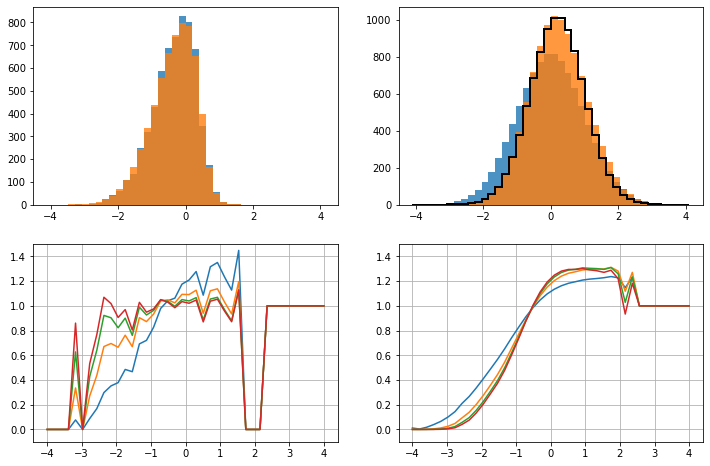




 All Done



CPU times: user 5min 34s, sys: 13.2 s, total: 5min 48s
Wall time: 5min 32s


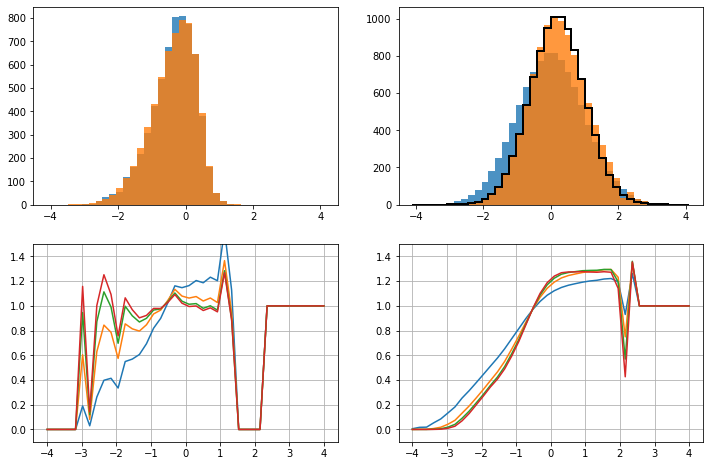

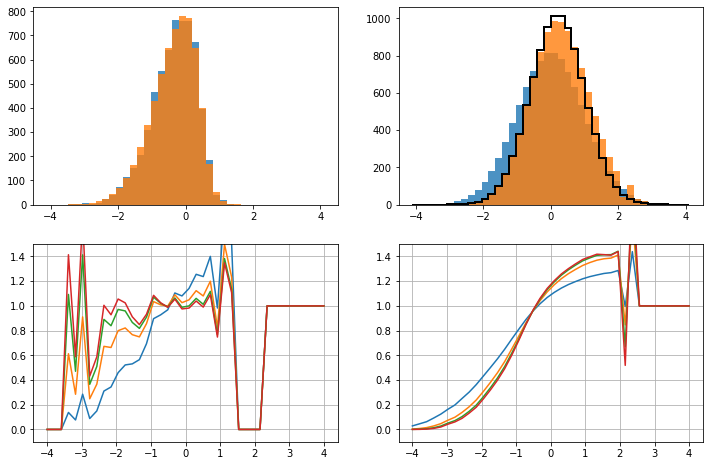

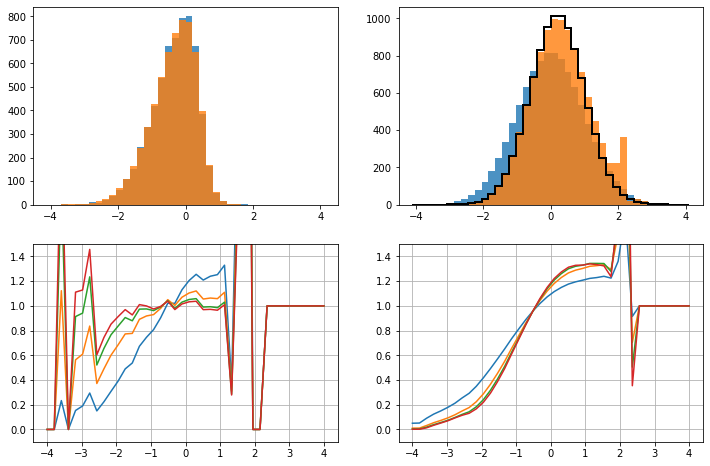

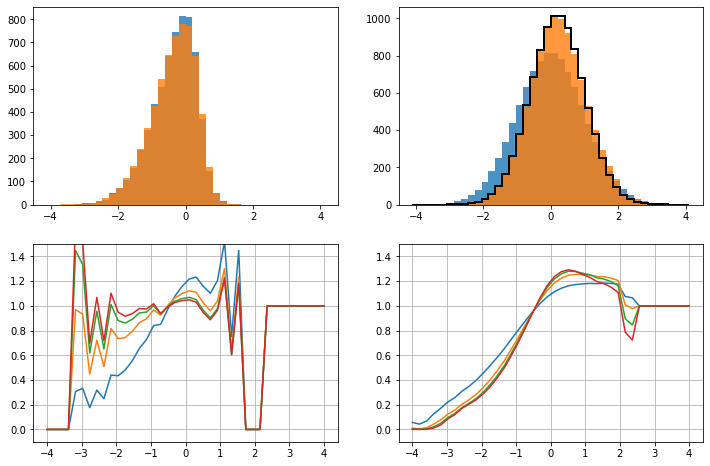

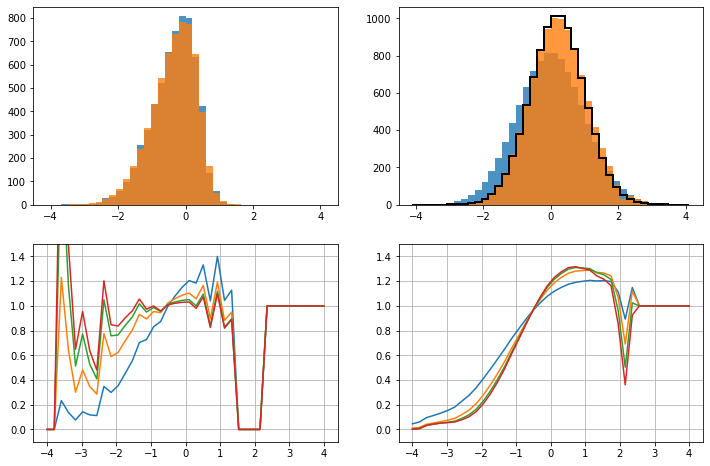

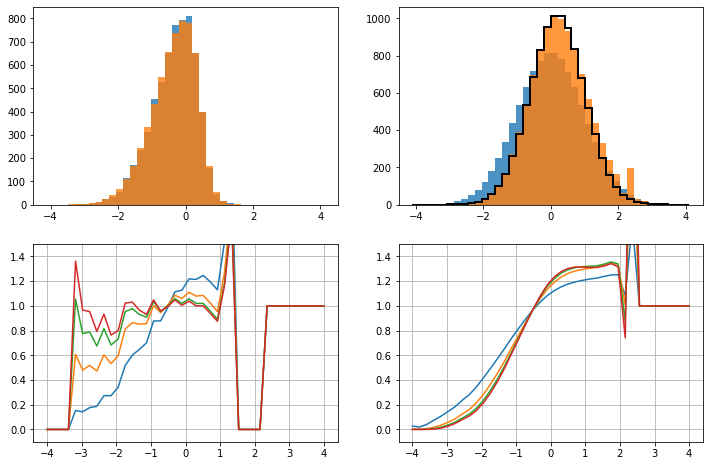

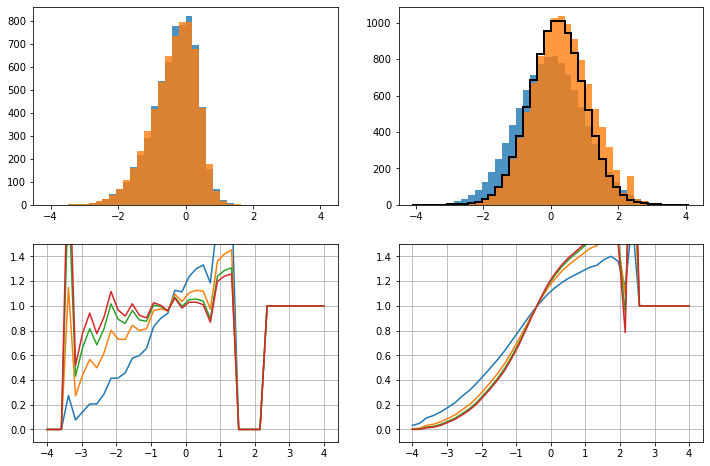

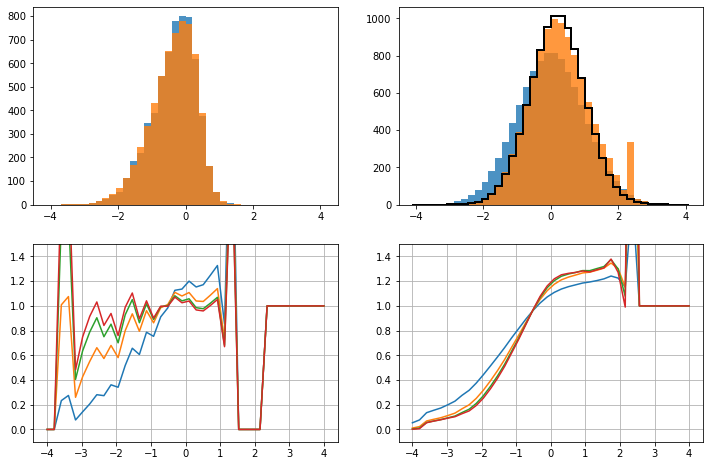

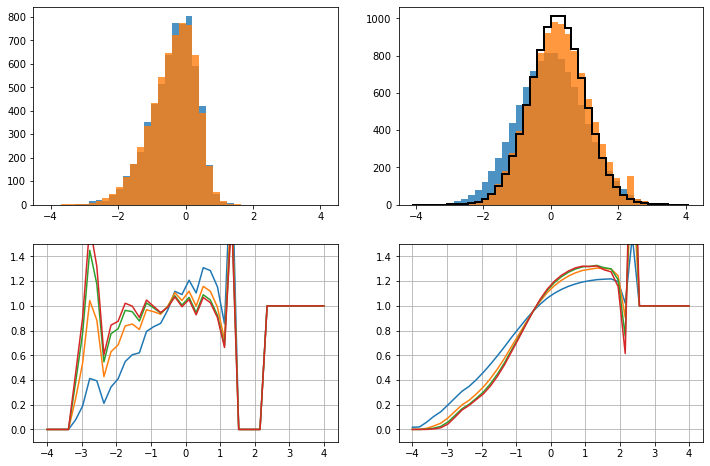

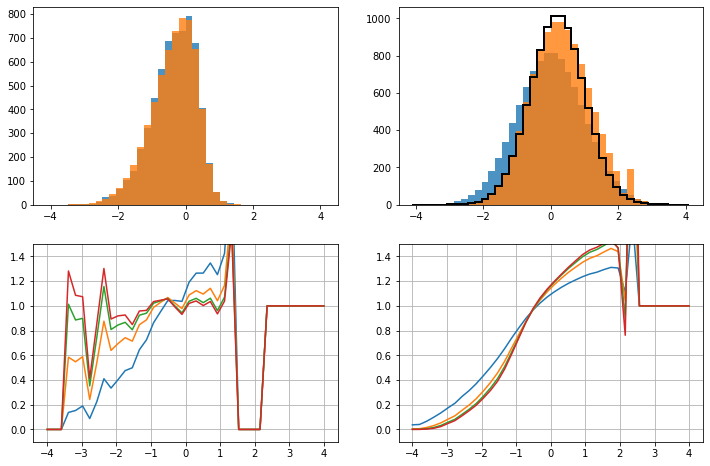

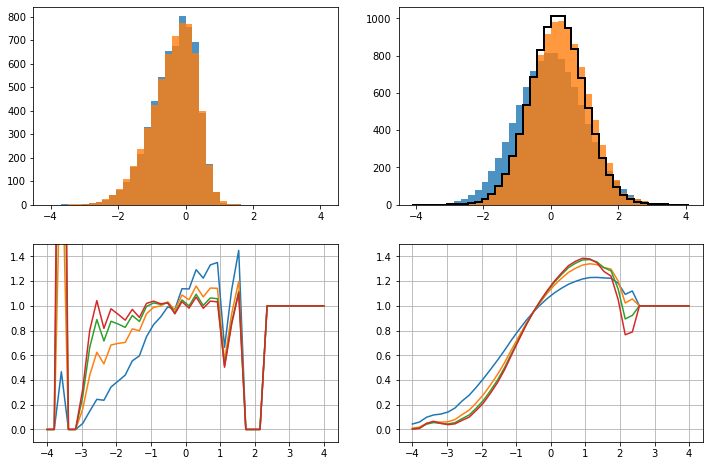

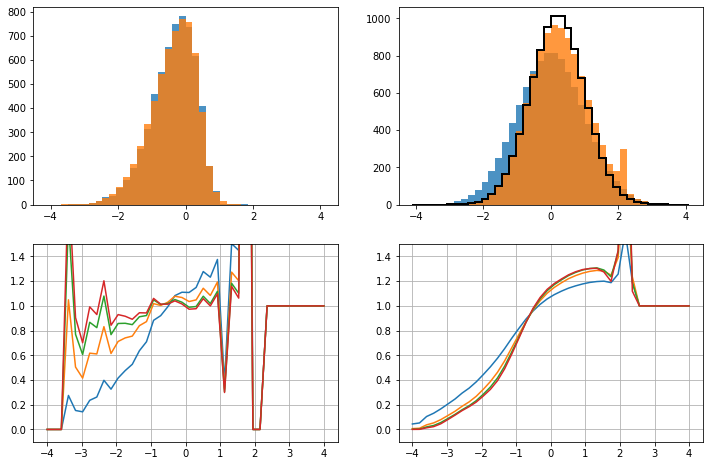

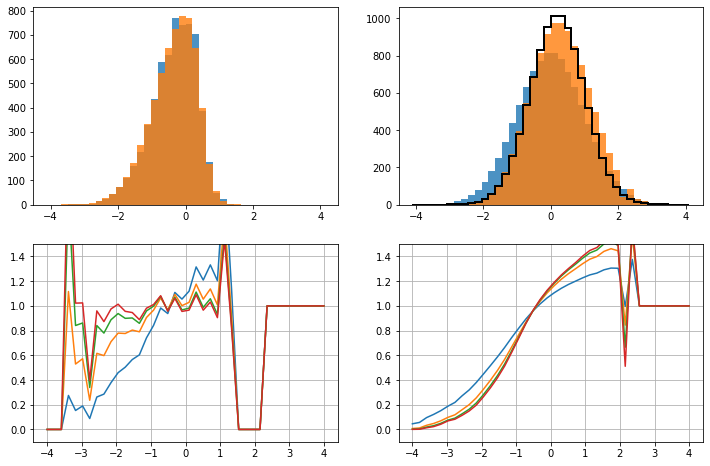

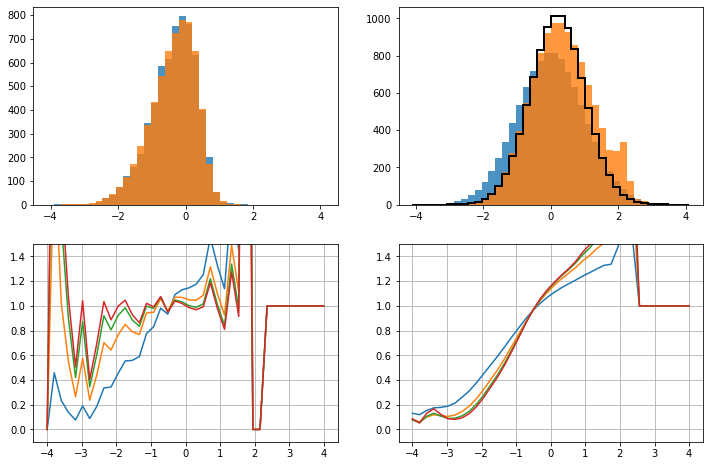

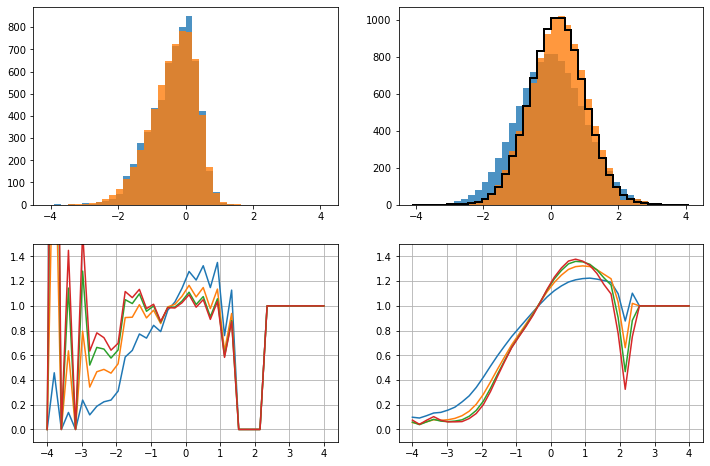

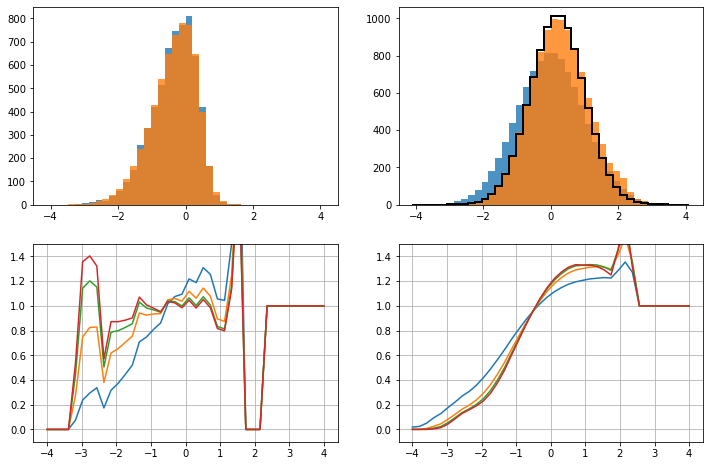

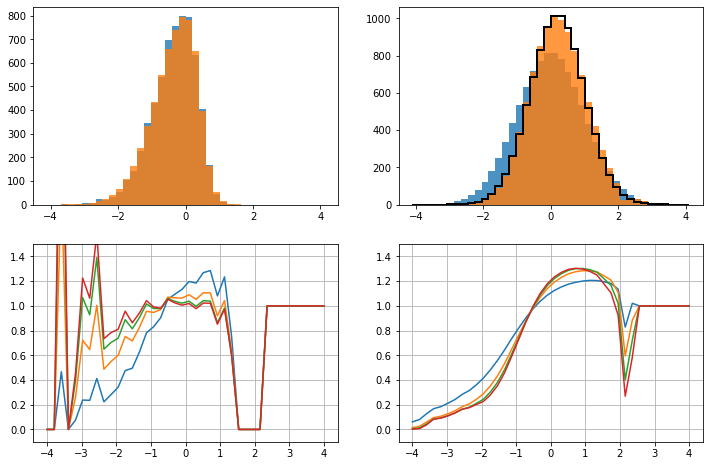

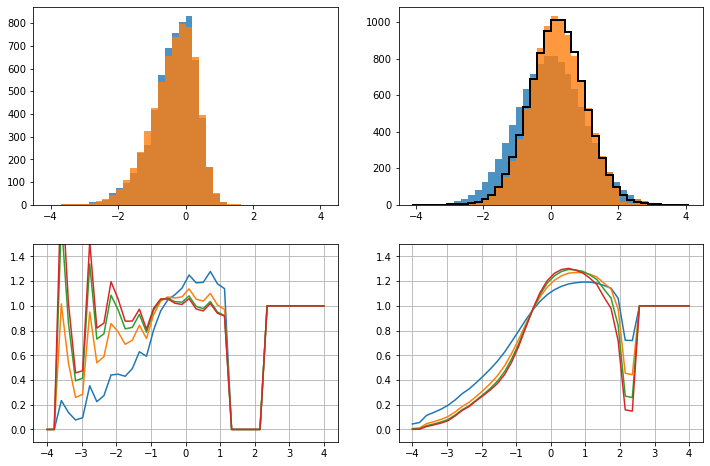

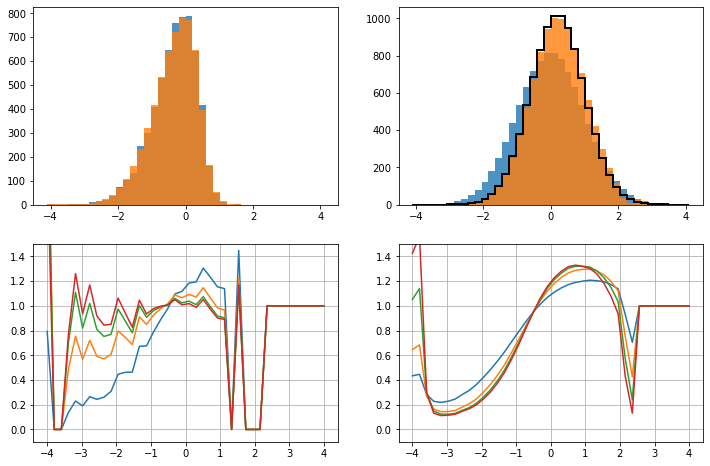

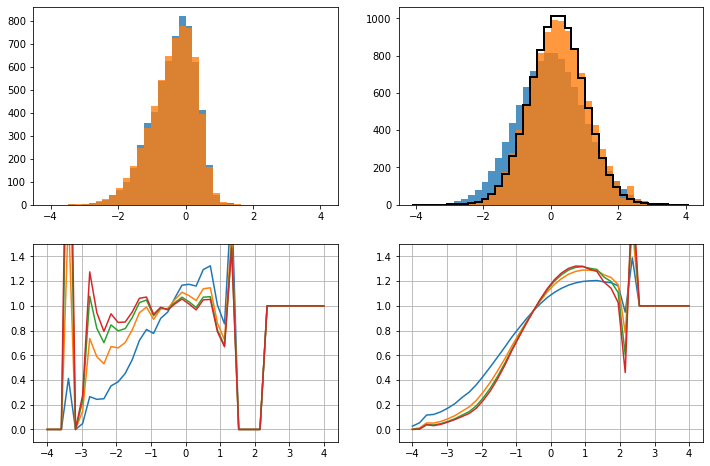

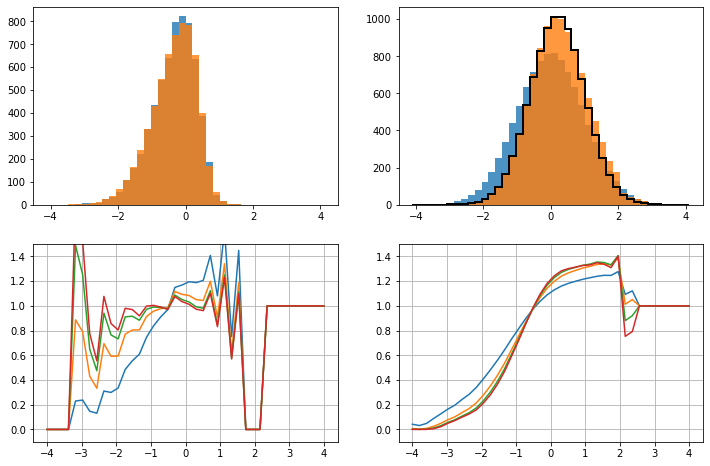

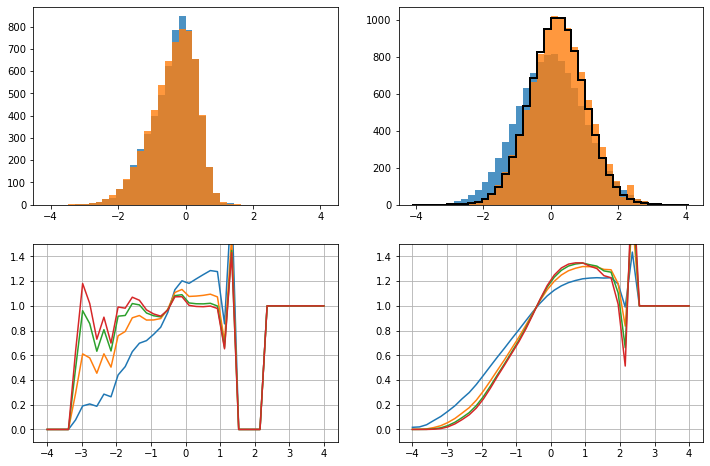

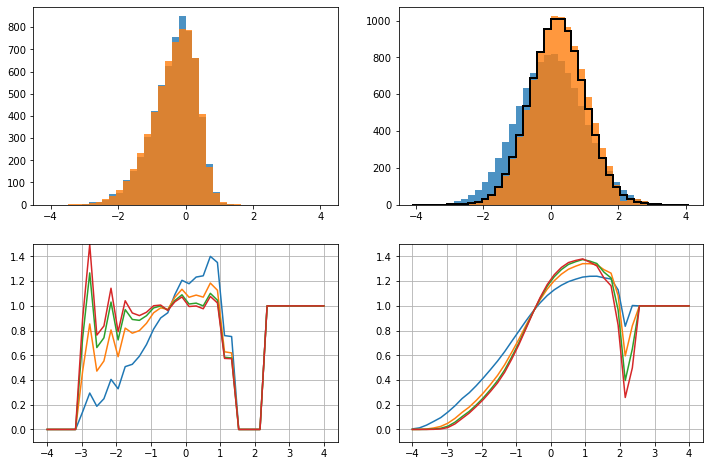

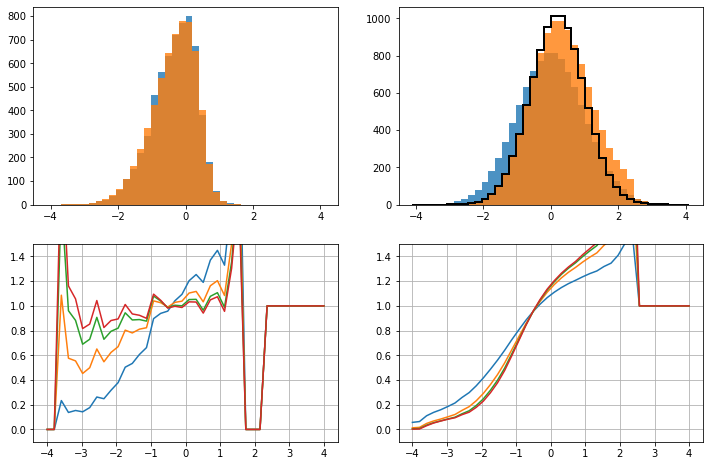

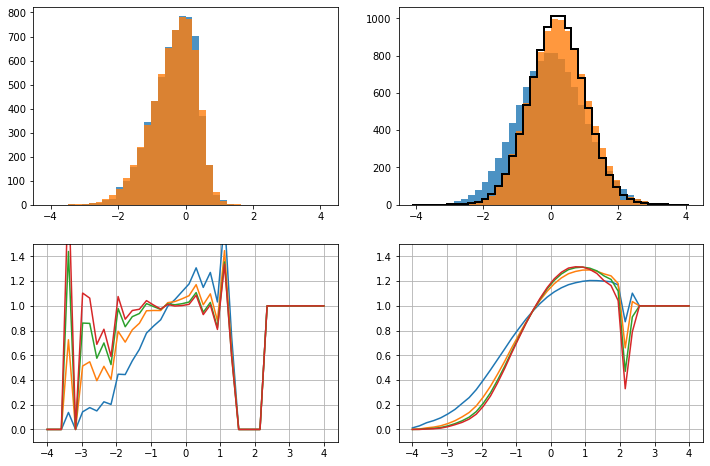

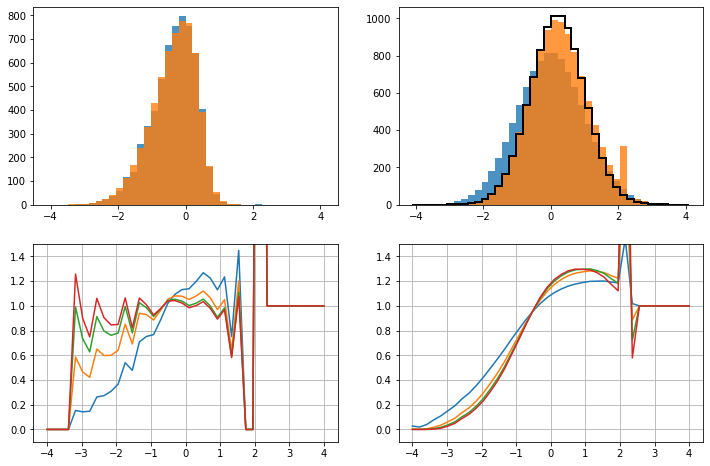

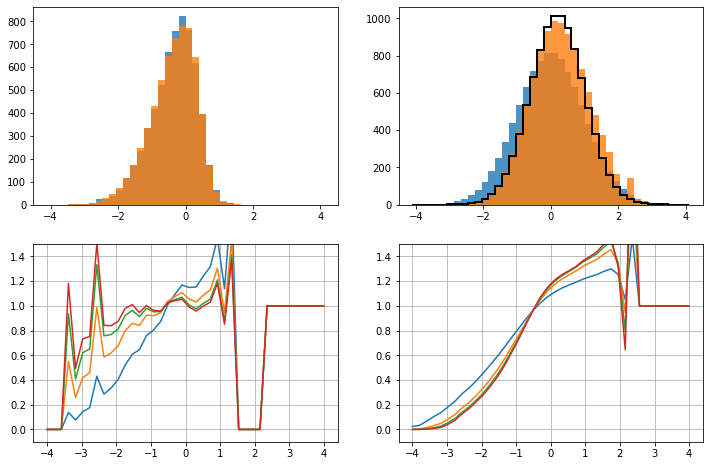

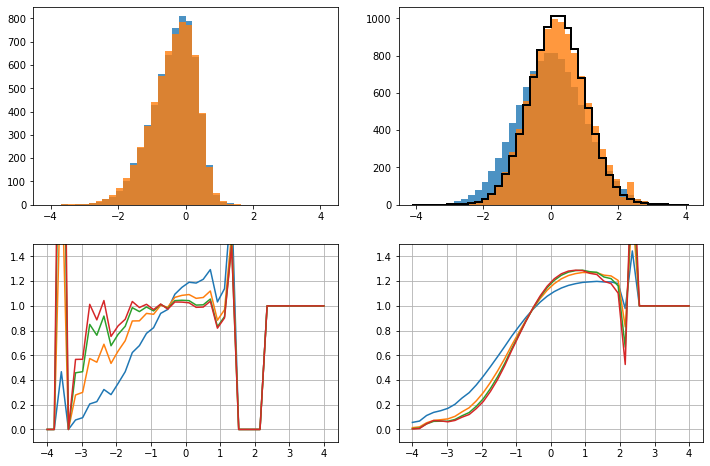

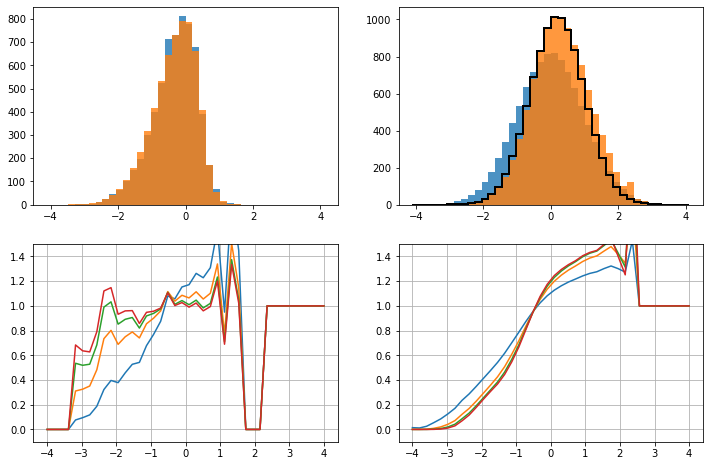

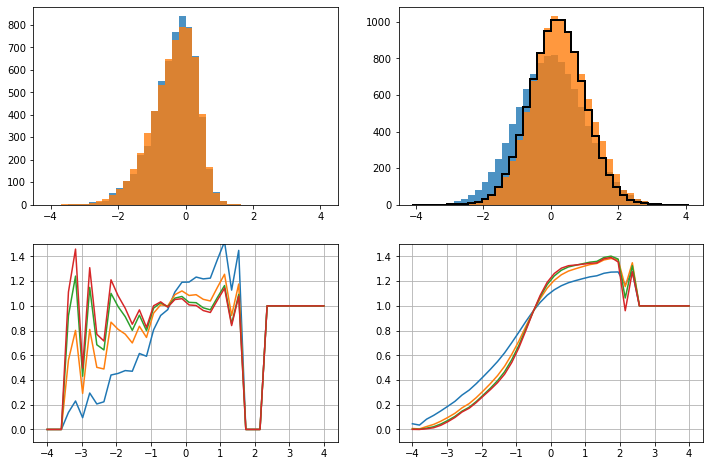

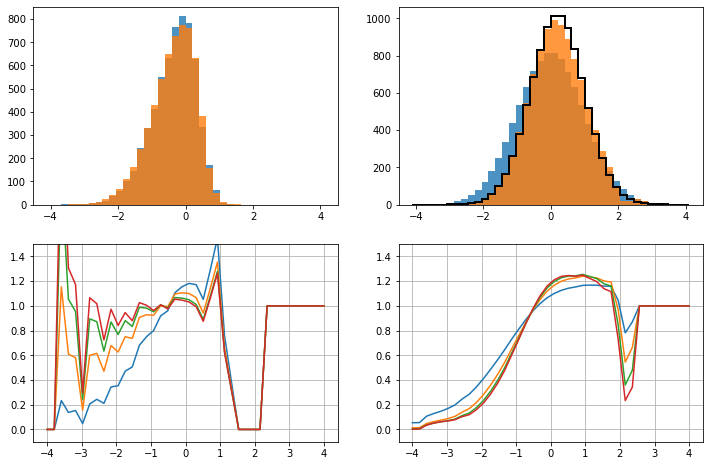

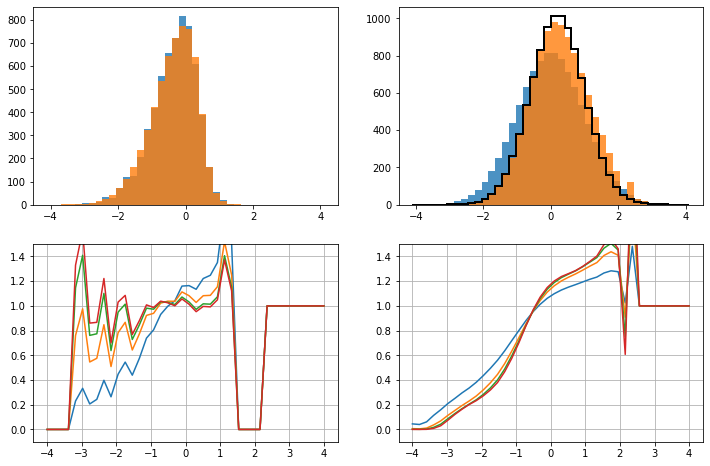

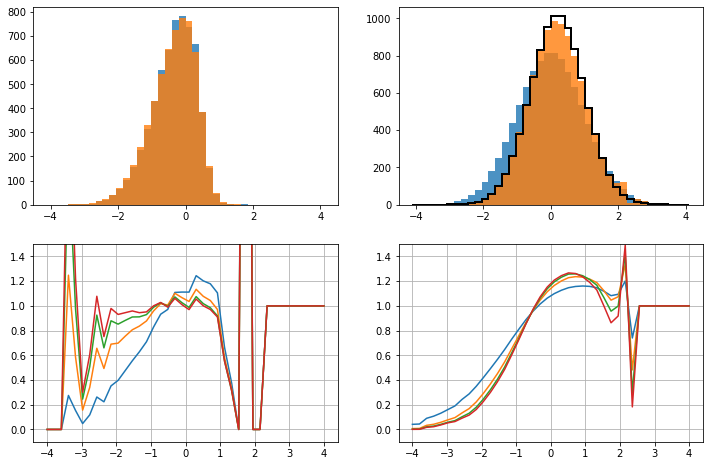

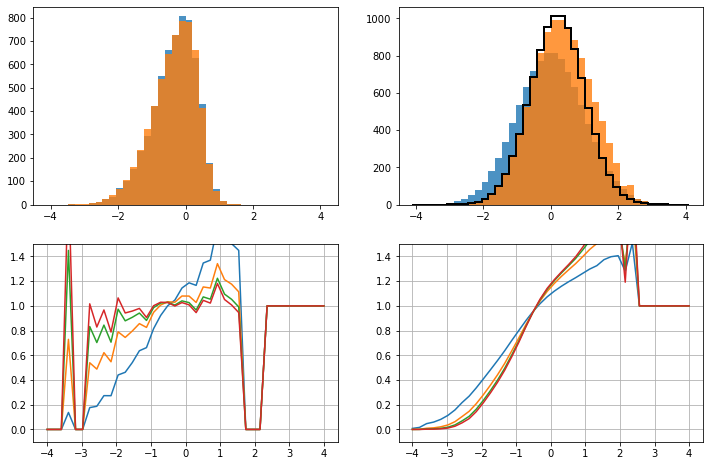

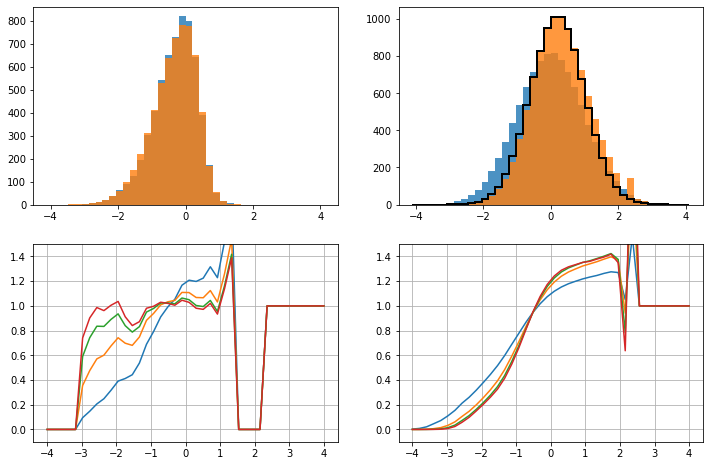

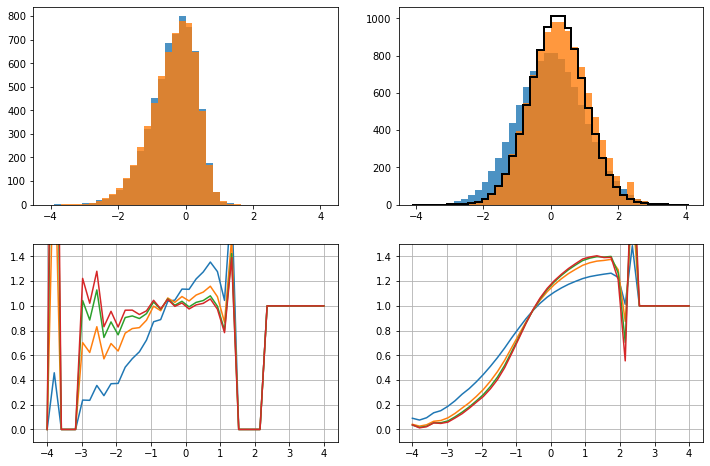

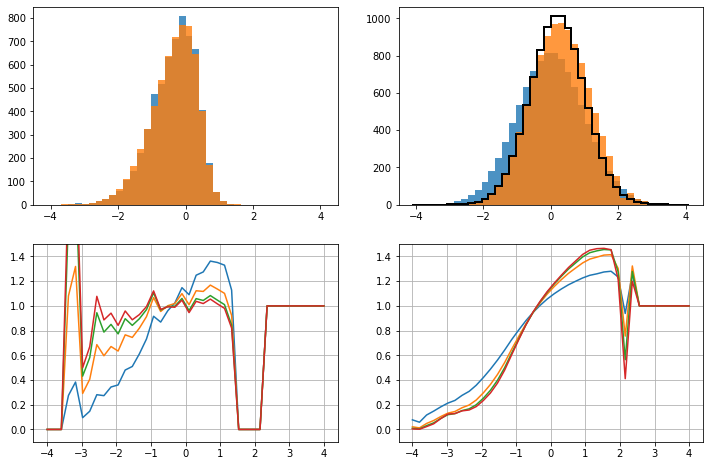

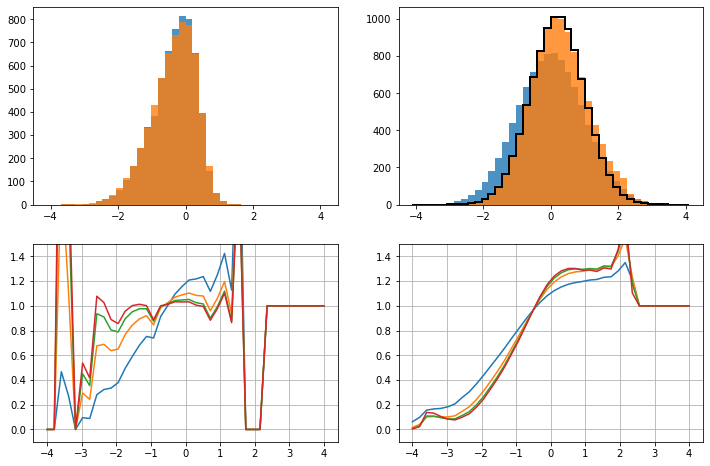

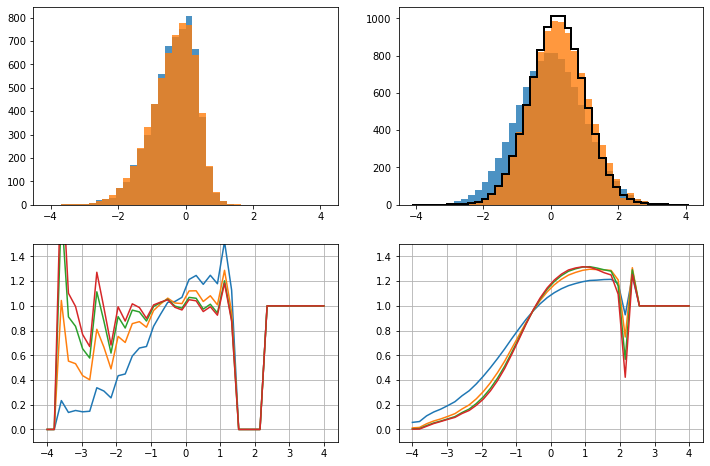

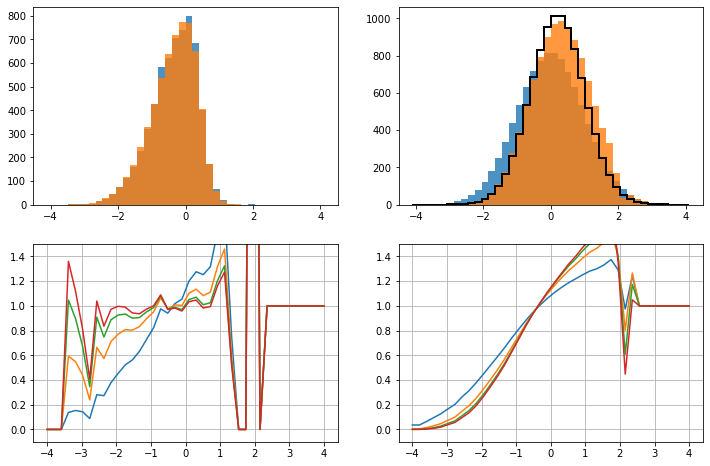

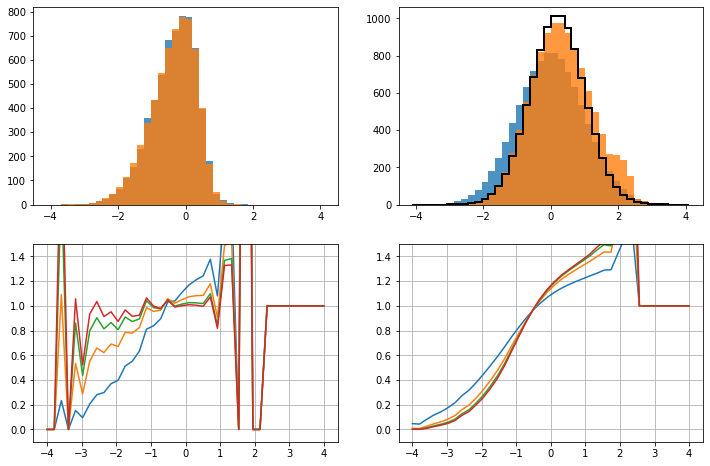

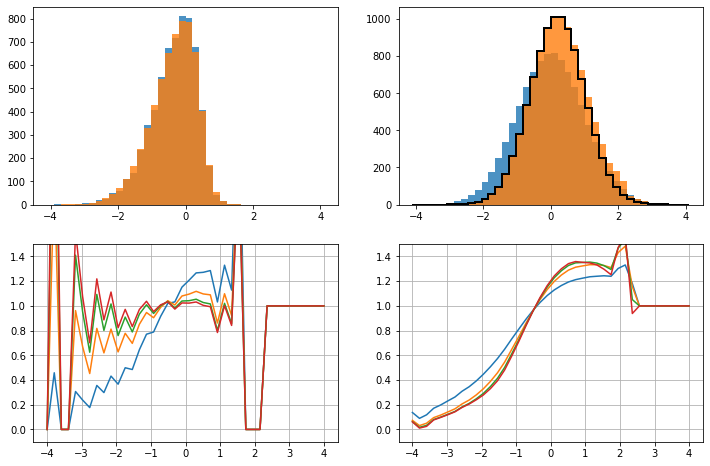

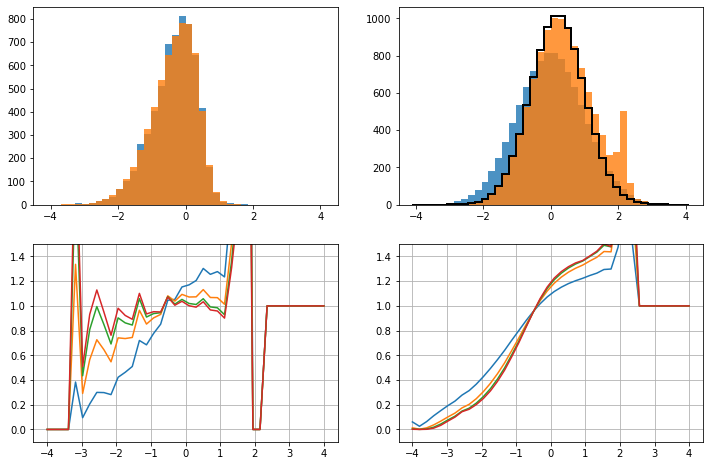

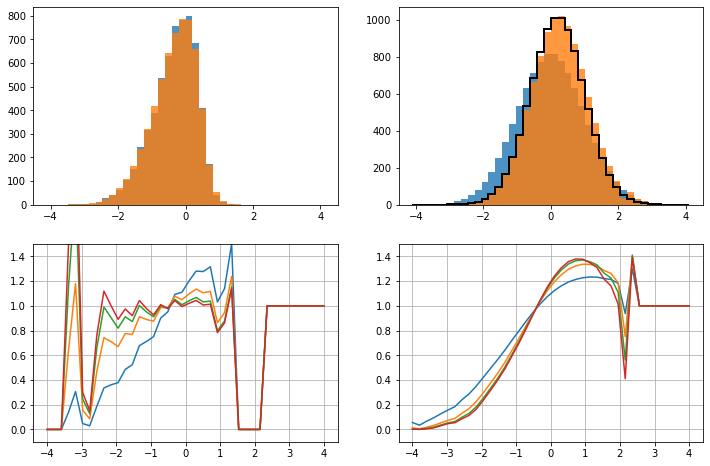

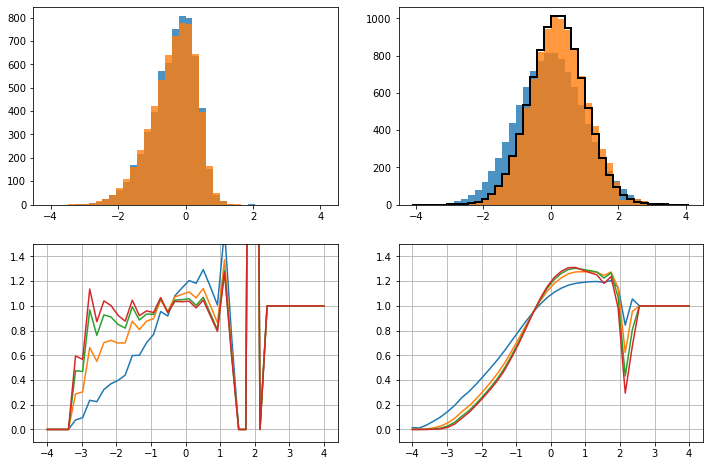

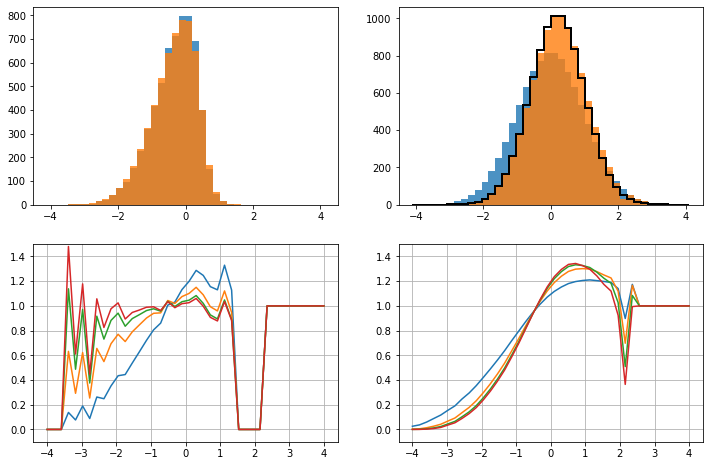

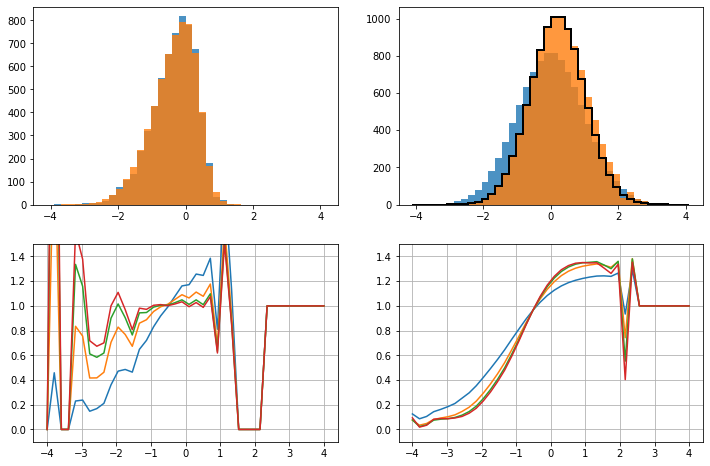

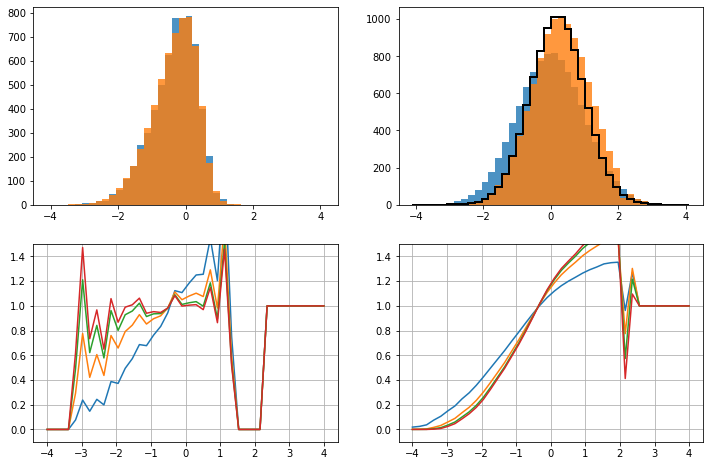

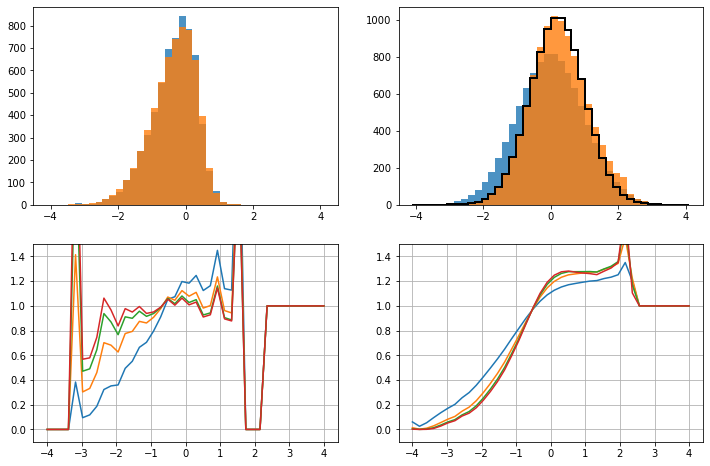

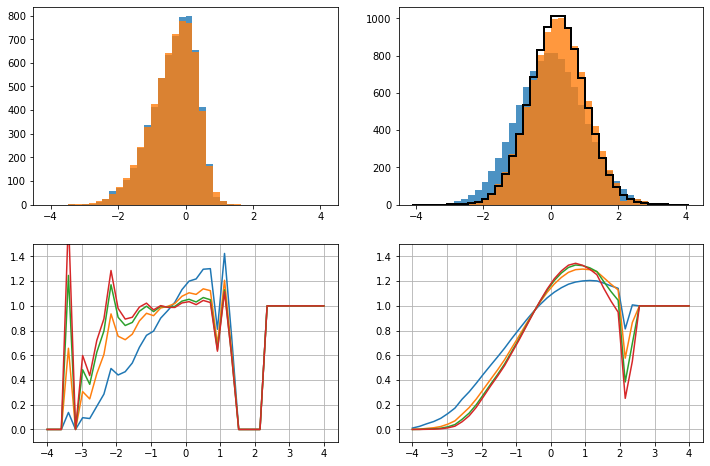

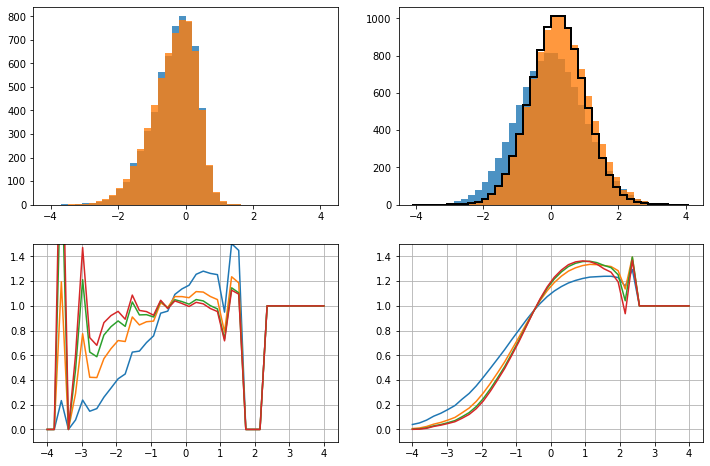

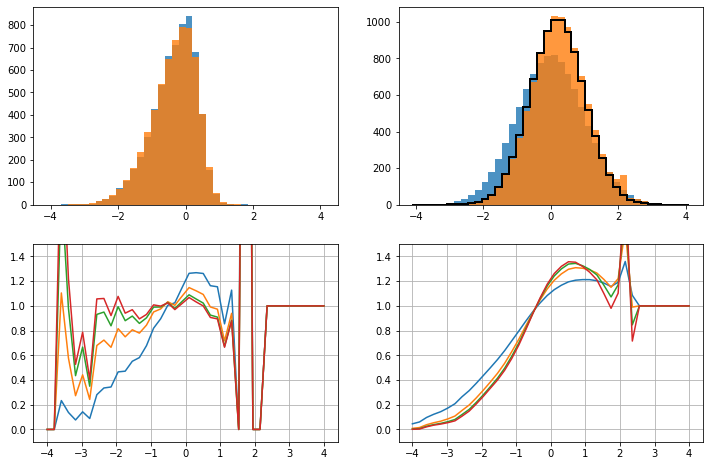

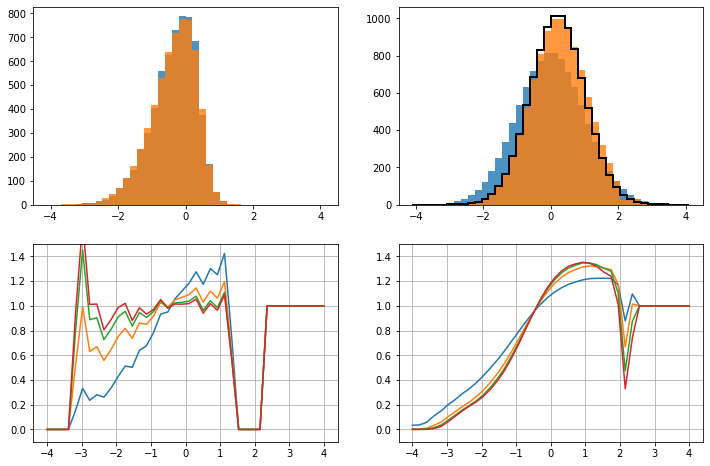

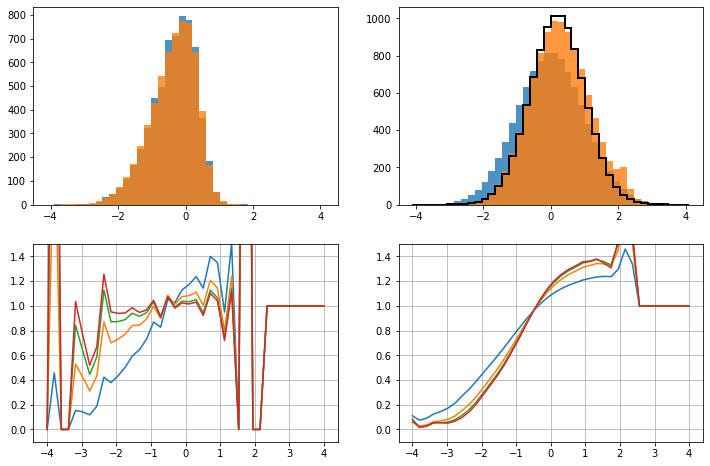

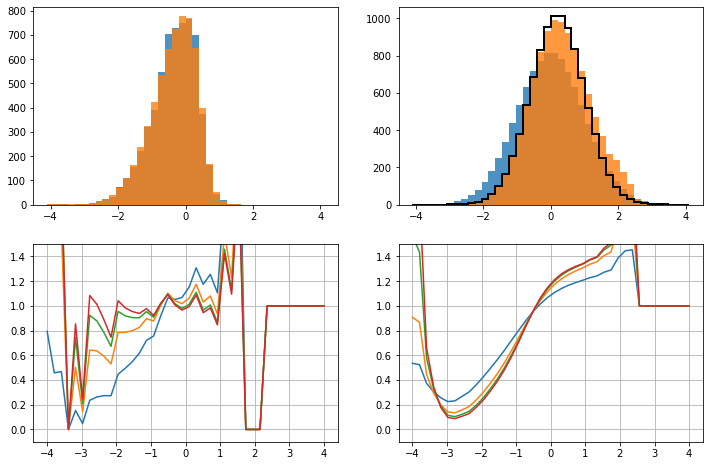

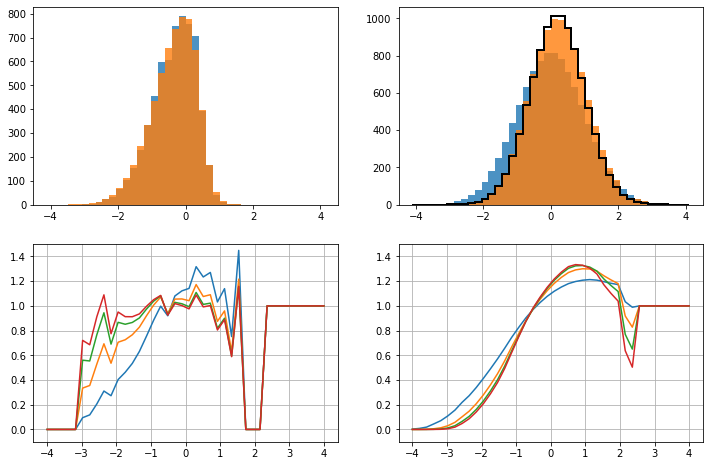

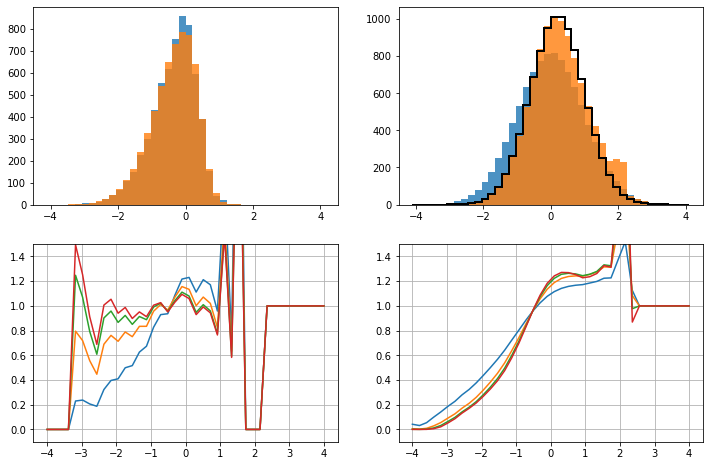

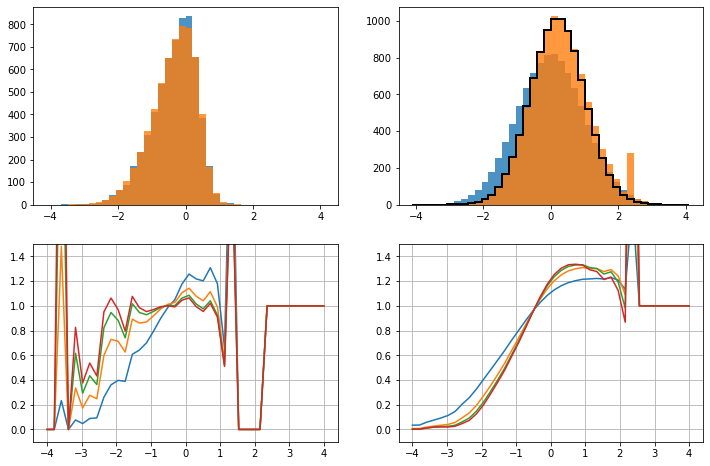

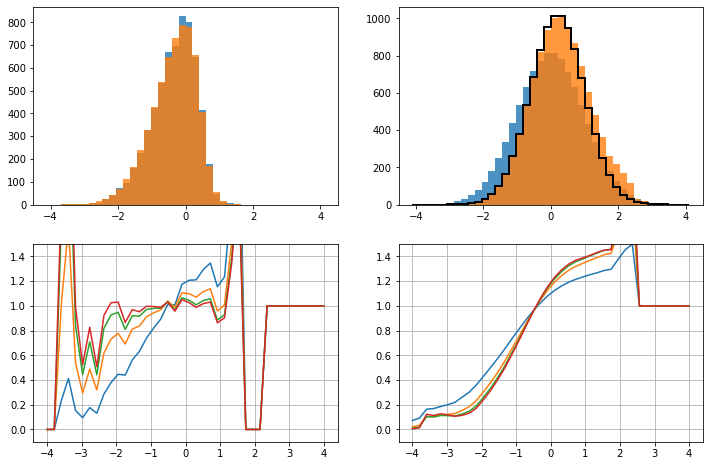

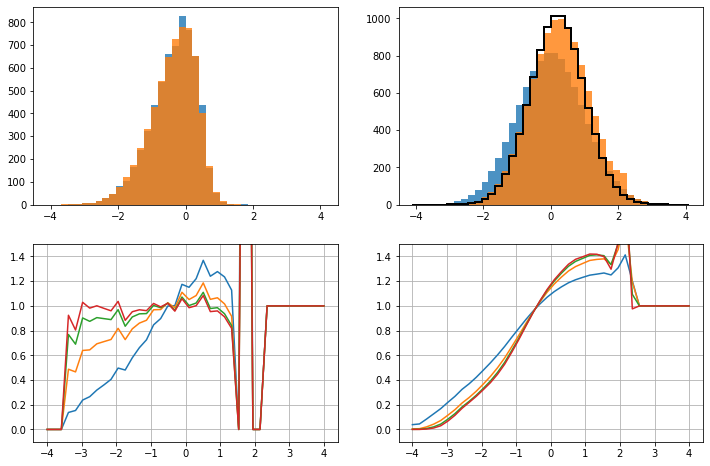

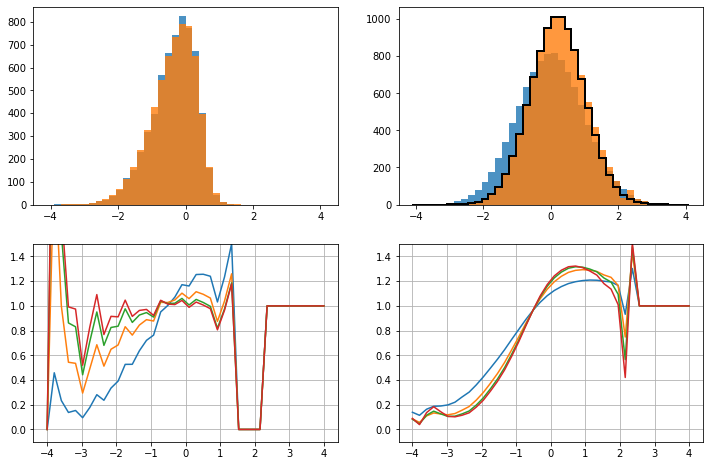

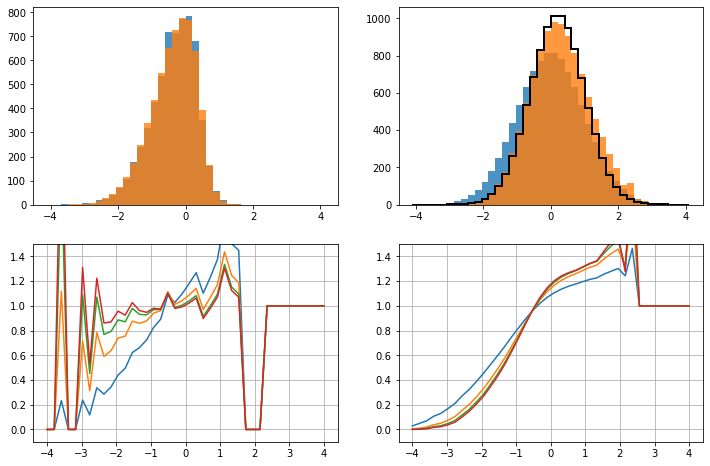

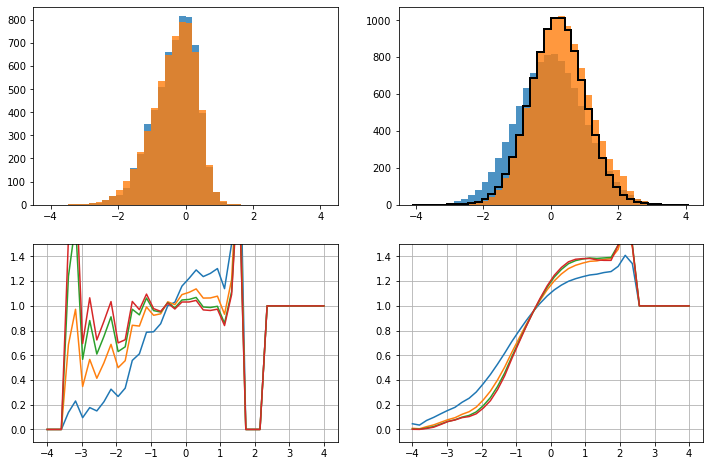

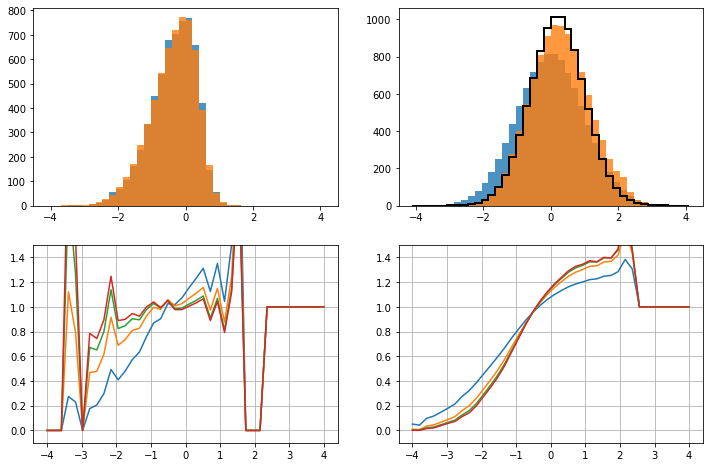

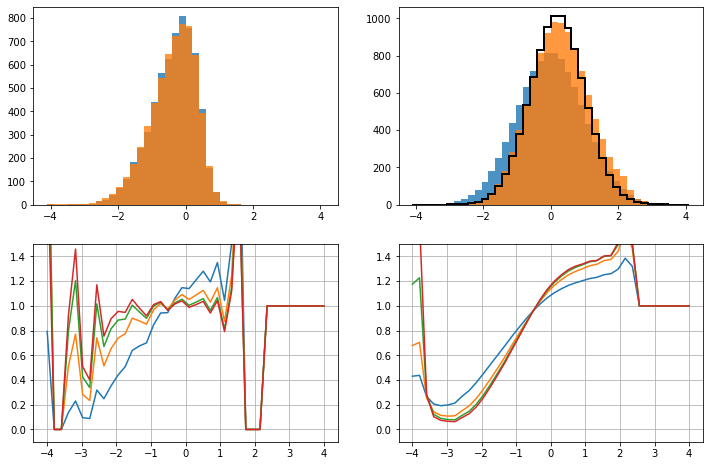

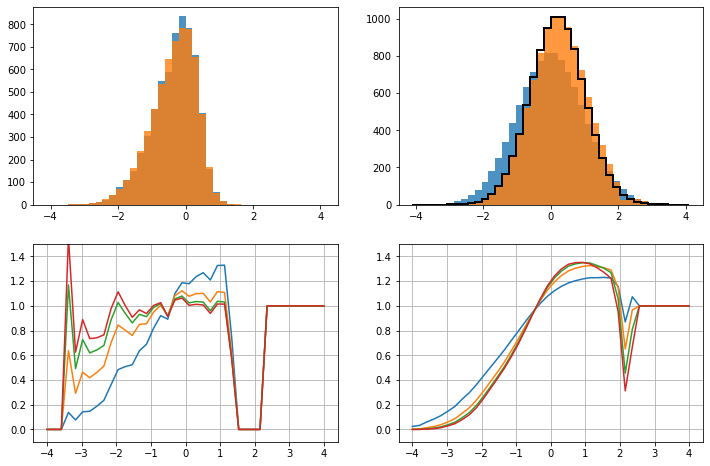

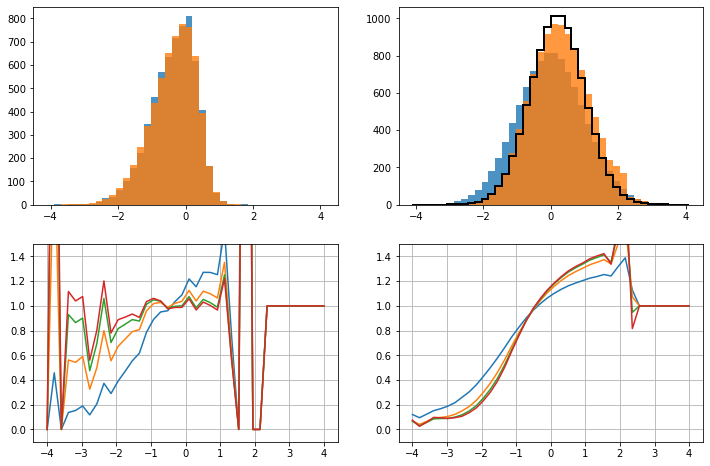

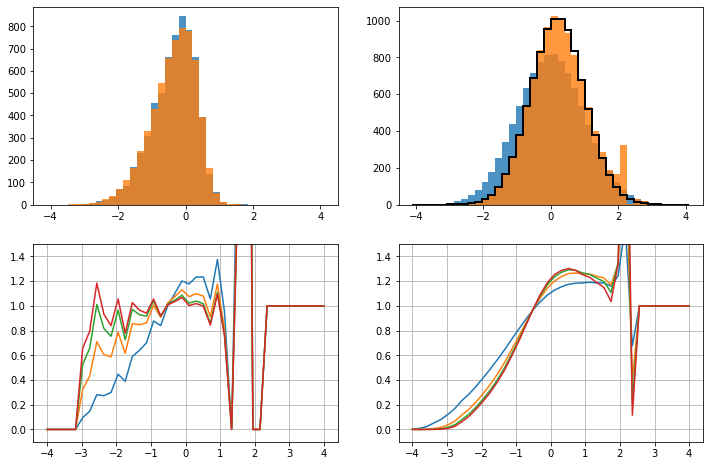

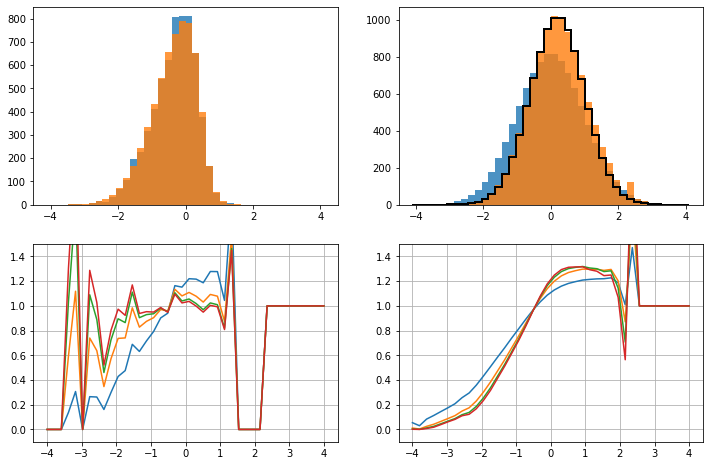

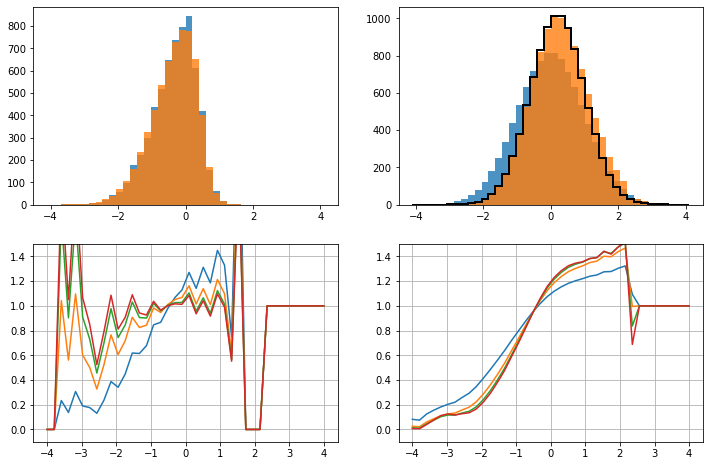

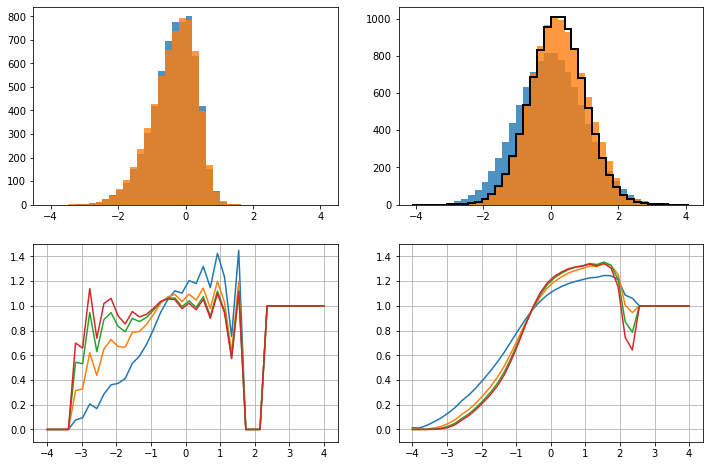

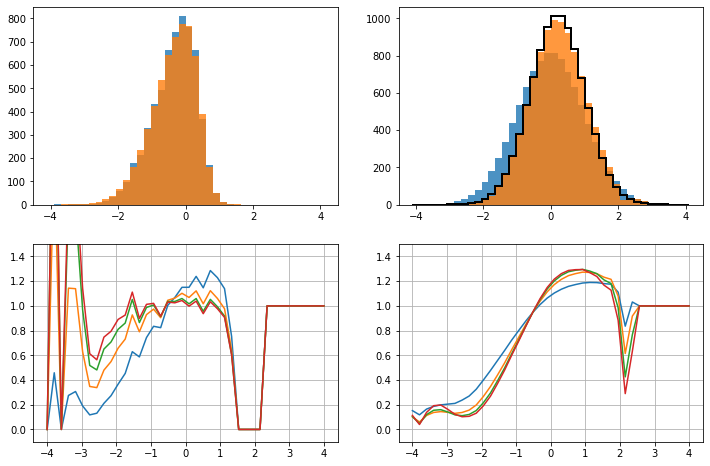

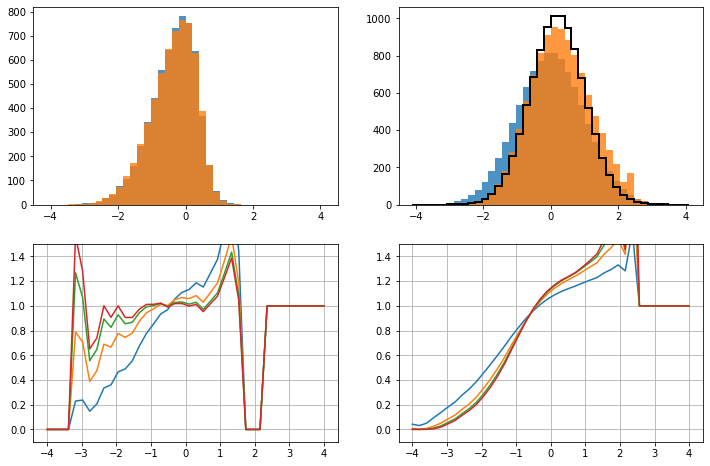

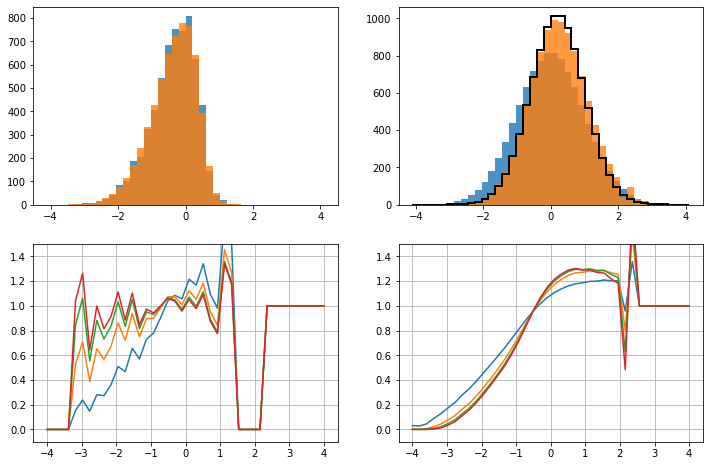

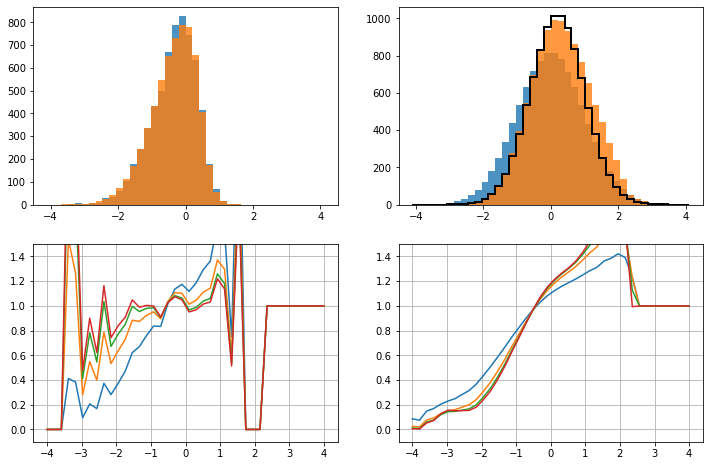

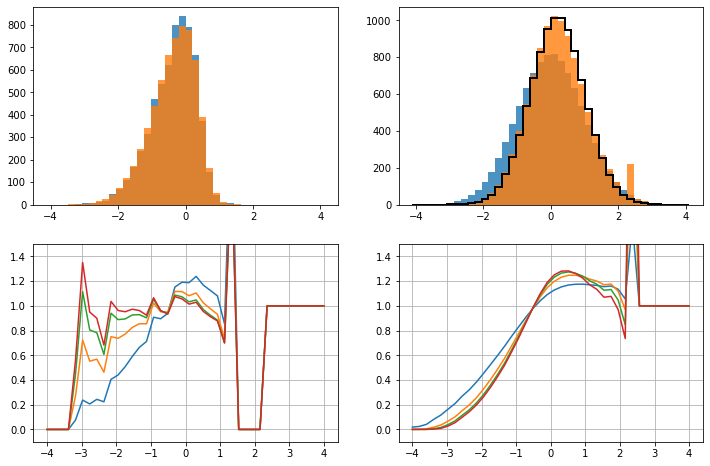

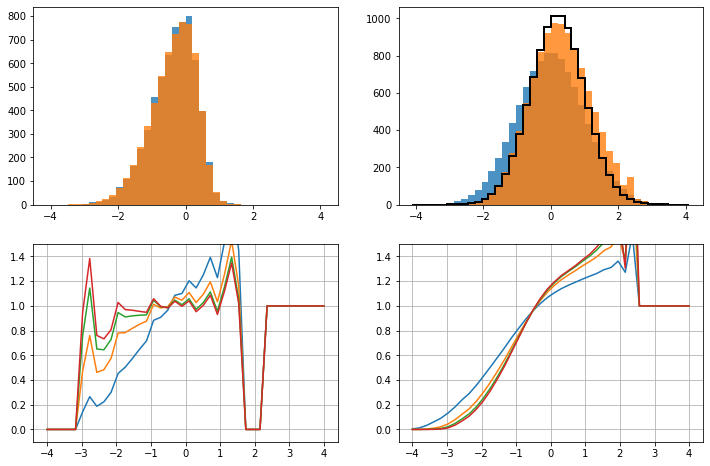

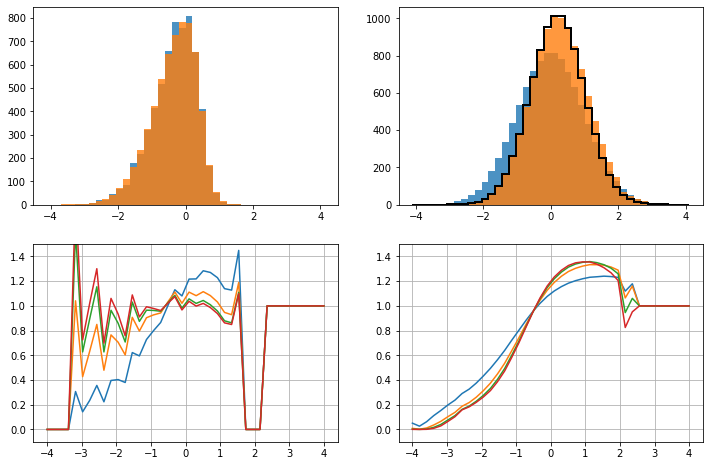

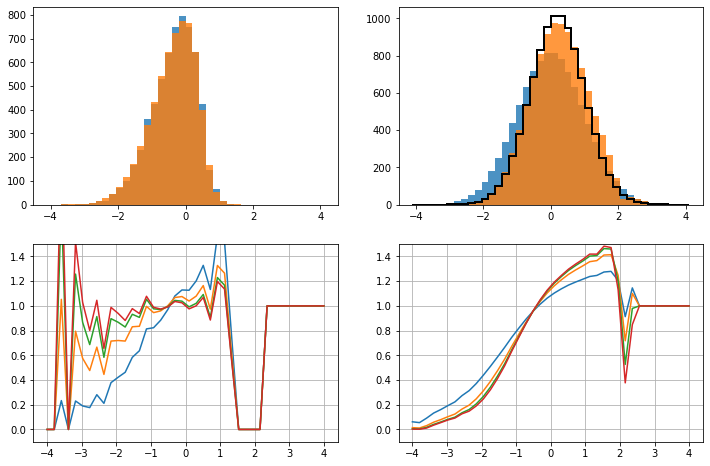

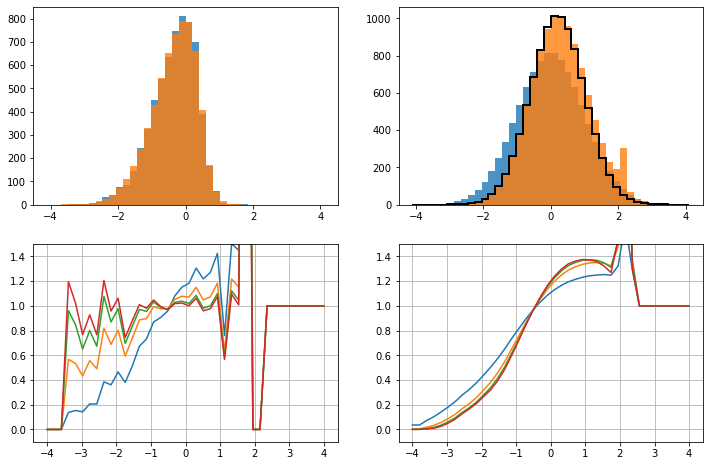

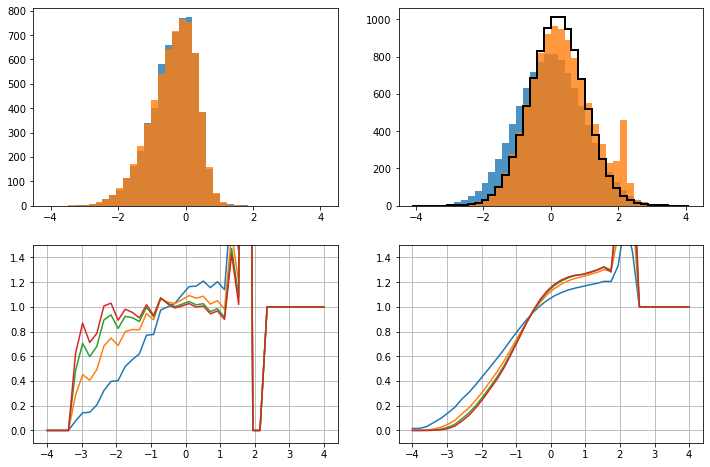

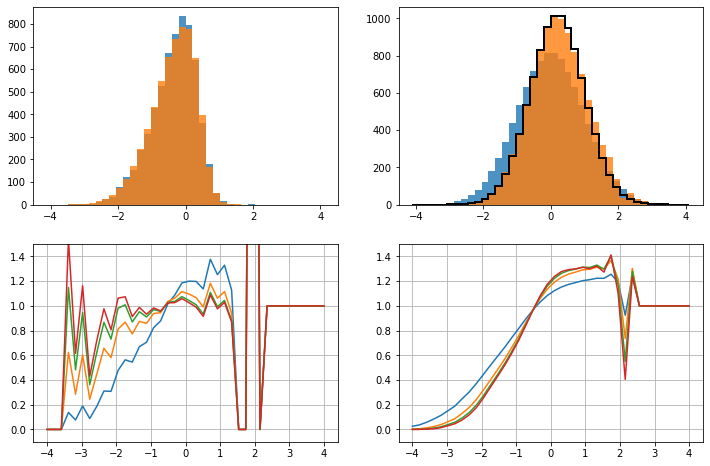

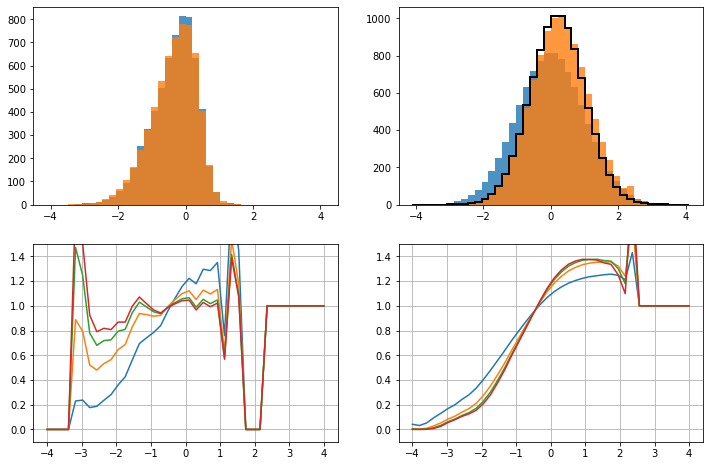

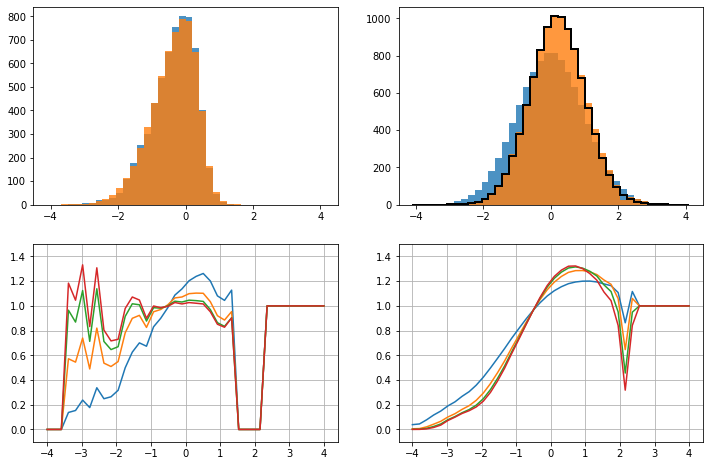

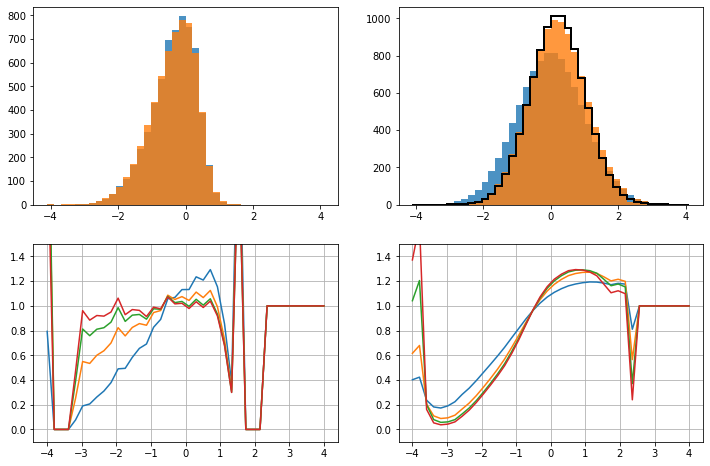

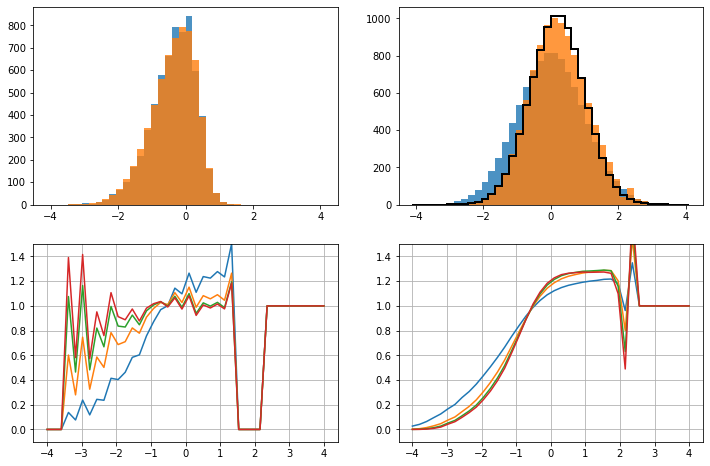

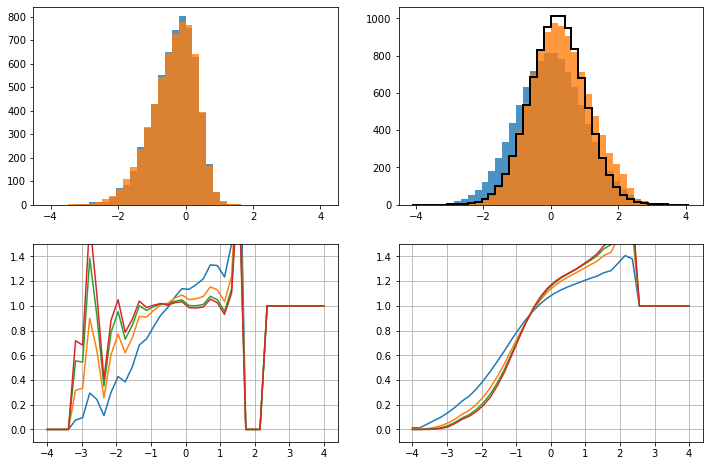

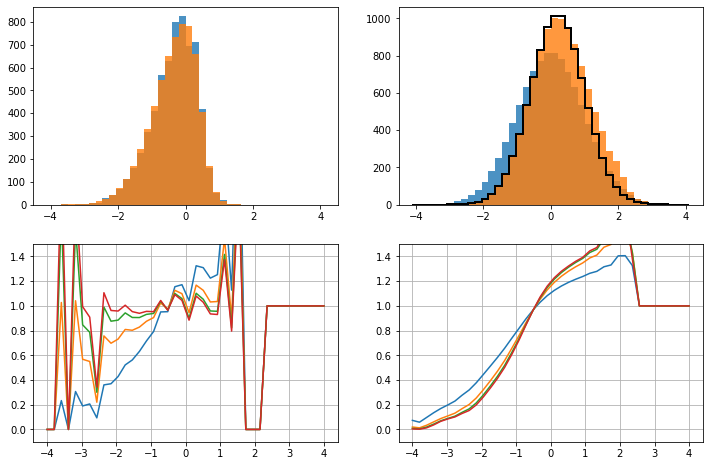

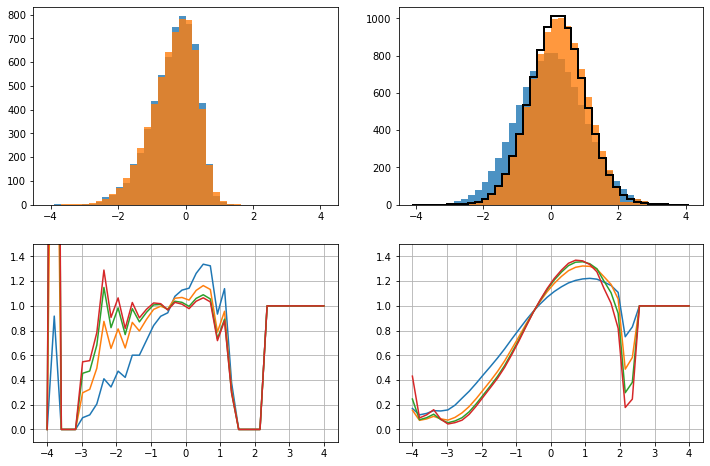

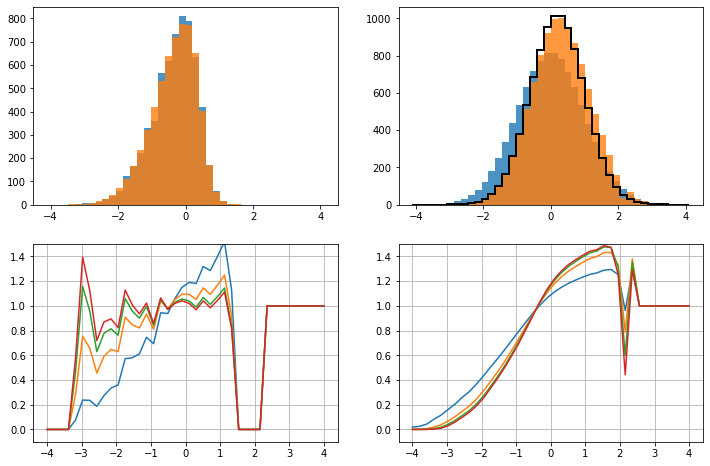

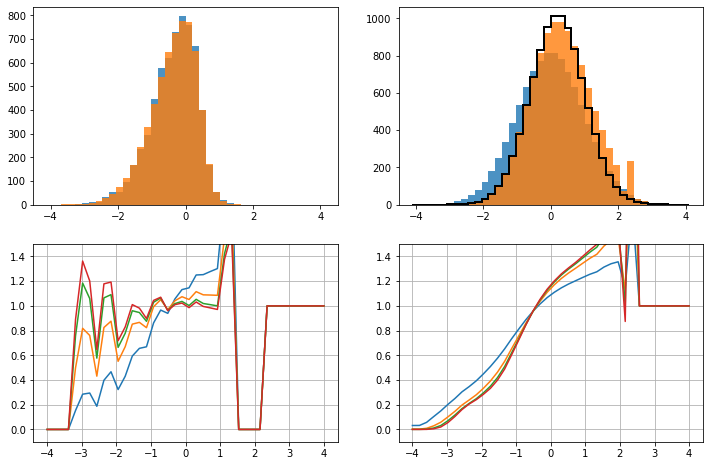

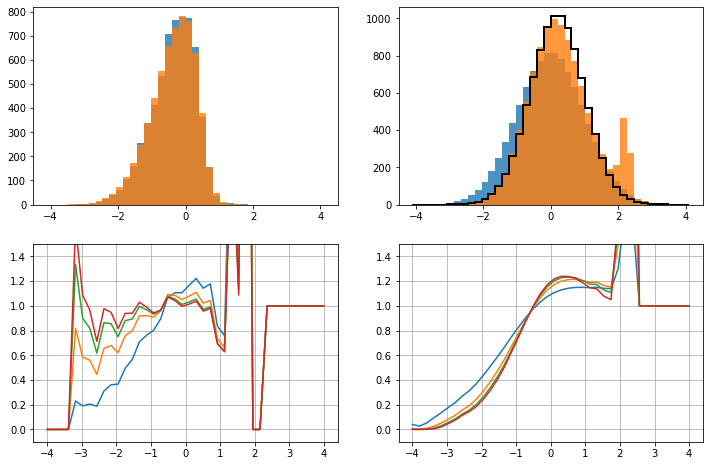

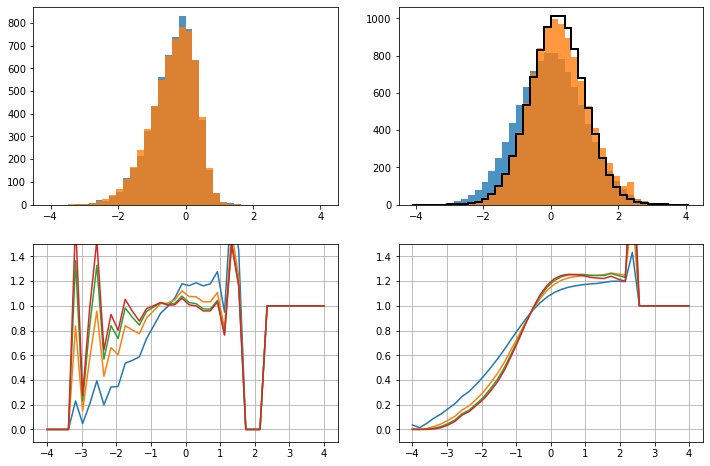

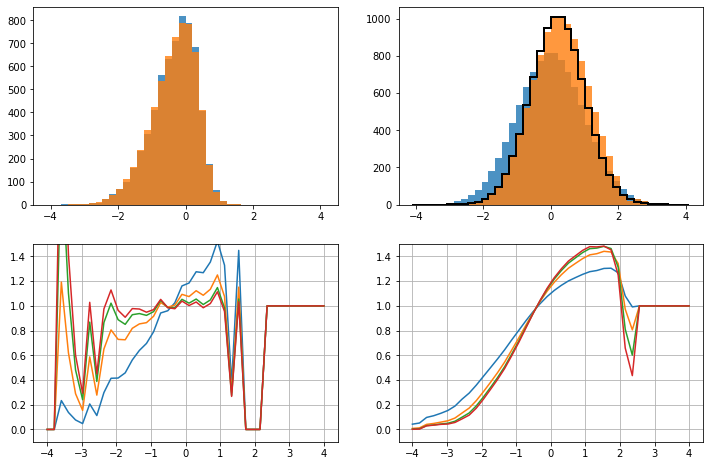

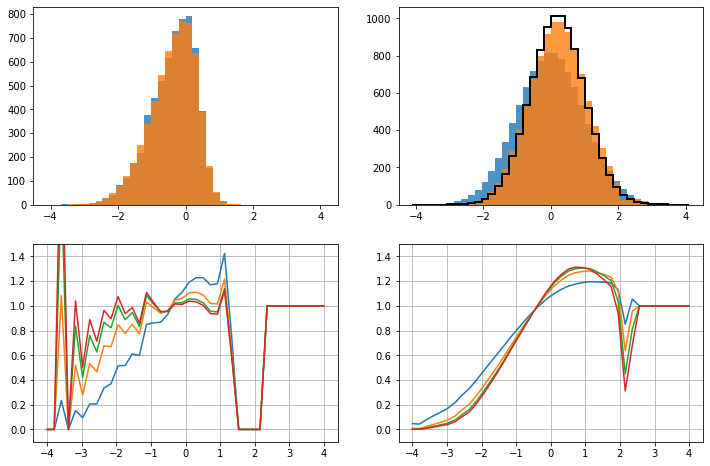

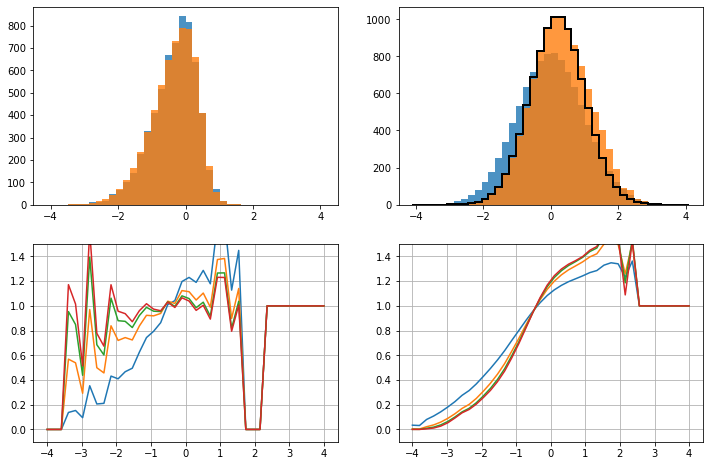

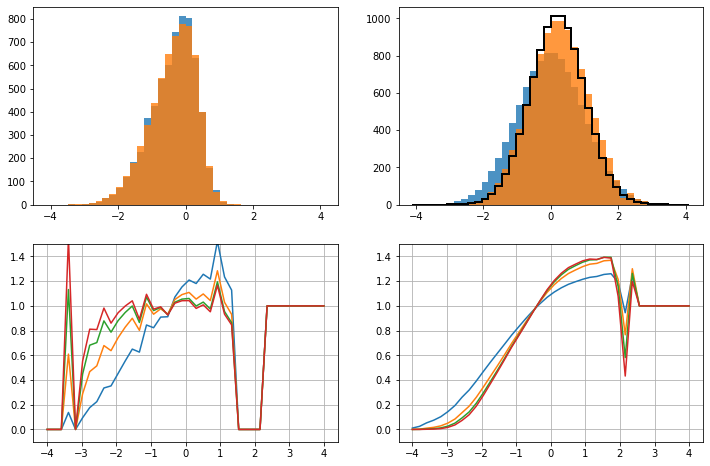

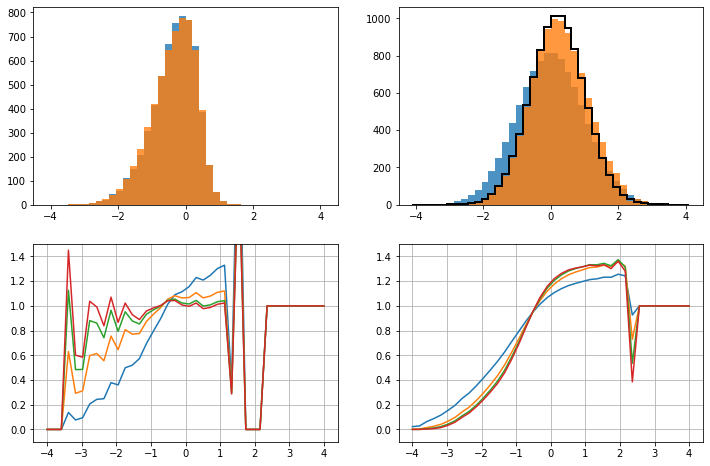

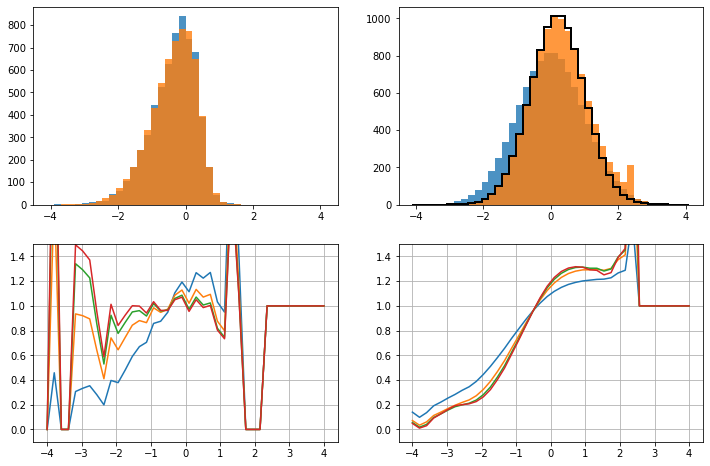

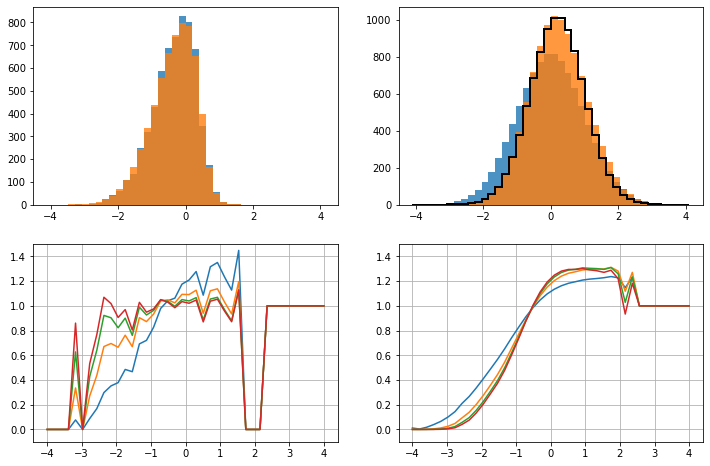

In [53]:
%%time

#do_bootstrap = True
do_bootstrap = False

for bi in range(0,n_boot_samples) :
    
    if do_bootstrap :
        print("Creating bootstrap sample %d" % bi)
        boot_nat_acc = np.random.choice( toy_nat_acc, len(toy_nat_acc))
    else:
        print("Creating toy sample %d" % bi)
        toy_nat0 = np.concatenate( [
            np.random.normal( nat_mu0c, nat_sigma0c, np.int32(np.rint(N_toy*nat_fc)) ),
            np.random.normal( nat_mu0t, nat_sigma0t, np.int32(np.rint(N_toy*(1.-nat_fc))) ) ]
        )

        toy_nat = np.array( toy_nat0 + np.random.normal( reso_delta, reso_sig, N_toy) )

        toy_acc_val_nat = 1./(1+np.exp(acc_w*(toy_nat-acc_t)))
        toy_acc_nat_rndm = np.random.uniform(0,1,N_toy)

        toy_nat_acc = np.array(toy_nat)
        toy_nat_acc[toy_acc_nat_rndm>toy_acc_val_nat] = dummyval
        
        boot_nat_acc = np.array( toy_nat_acc )


        
        
        
    pull_weights = np.ones( len(toy_sim) )
    push_weights = np.ones( len(toy_gen0) )



    #print("\n\n Bootstrap %3d :  Initialization." % bi )




    fig,ax = plt.subplots(2,2,figsize=(12,8))

    for i in range(0,iterations) :
    
        print("\n\n ======== Bootstrap  %3d , Iteration %d" % (bi, i) )
    
        display.clear_output(wait =True)

    
    
    
        #-- step 1  ---------------------------------------------------------
    
        ax[0][0].cla()
        #-- this is with finite acceptance
        hist_nat = ax[0][0].hist( boot_nat_acc, bins=x_bins, alpha=0.8 )
        hist_sim = ax[0][0].hist( toy_sim_acc, bins=x_bins, weights=push_weights*weights0_mc, alpha=0.8 )    
    
        hist_sim_safe = np.clip(hist_sim[0],1e-9,1e25)
        hist_nat_safe = np.clip(hist_nat[0],1e-9,1e25)
    
        weight_step1 = hist_nat_safe / hist_sim_safe
    
        weight_step1_clipped = np.clip(weight_step1, -10, 10)
    
        ax[1][0].plot(x, weight_step1_clipped)
        ax[1][0].grid(True)
        ax[1][0].set_ylim(-0.1,1.5)
    
    
        pull_weights = push_weights * weight_step1_clipped[ toy_sim_bin_indices_safe ]


    
    
    
        #-- reset weights for events that don't pass reco.
    
        #-- simplest possible way:  set them equal to 1.
        #     This way gives very biased results!
        #pull_weights[ toy_sim_acc==dummyval ] = 1
    
    
        #-- this is the way it's done in Ben's GaussianExample
        #     Using np.histogram because I don't need to see these, just need the data for the hist bins.
        alt_hist_w0 = np.histogram( toy_gen0[toy_sim_acc!=dummyval], 
                                   weights=weights0_mc[toy_sim_acc!=dummyval], bins=x_bins )
        alt_hist_wp = np.histogram( toy_gen0[toy_sim_acc!=dummyval], bins=x_bins, 
                                   weights=pull_weights[toy_sim_acc!=dummyval]*weights0_mc[toy_sim_acc!=dummyval] )    

        alt_hist_w0_safe = np.clip(alt_hist_w0[0],1e-9,1e25)
        alt_hist_wp_safe = np.clip(alt_hist_wp[0],1e-9,1e25)

        alt_weight_step1 = alt_hist_wp_safe / alt_hist_w0_safe

        alt_weight_step1_clipped = np.clip(alt_weight_step1, -10, 10)
    
        pull_weights[ toy_sim_acc==dummyval ] = alt_weight_step1_clipped[ toy_gen0_bin_indices_safe[ toy_sim_acc==dummyval ] ]
    
    
    
    
    
    
    
    
    
    
    
    
        #-- step 2  ---------------------------------------------------------

        ax[0][1].cla()
        hist_gen0 = ax[0][1].hist( toy_gen0[pull_weights!=10], 
                                  weights=weights0_mc[pull_weights!=10], bins=x_bins, alpha=0.8)
        hist_genw = ax[0][1].hist( toy_gen0[pull_weights!=10], 
                                  weights=pull_weights[pull_weights!=10]*weights0_mc[pull_weights!=10], bins=x_bins, alpha=0.8)

        ax[0][1].hist( toy_nat0_100x, bins=x_bins, weights=weights_nat0_100x,
                      linewidth=2, density=False, color='black', histtype = 'step')
    
        hist_genw_binvals = hist_genw[0]
    
        if do_smooth:
            if ( i < (iterations-1) ):
                z = np.polyfit( x, hist_genw_binvals,15)
                p = np.poly1d(z)
                hist_genw_binvals = p(x)
    
    
        hist_genw_safe = np.clip(hist_genw_binvals,1e-9,1e25)
        hist_gen0_safe = np.clip(hist_gen0[0],1e-9,1e25)
    
        weight_step2 = hist_genw_safe / hist_gen0_safe
    
        weight_step2_clipped = np.clip(weight_step2, -10, 10)
    
        ax[1][1].plot(x, weight_step2_clipped)
        ax[1][1].grid(True)
        ax[1][1].set_ylim(-0.1,1.5)
    
        push_weights = weight_step2_clipped[ toy_gen0_bin_indices_safe ]
    
        #-- reset weights for events that don't pass truth (fakes or not correct true process).
        #   Nothing to do for this step in this toy.
        

        
        
        
        this_prediction = np.histogram( toy_gen0[pull_weights!=10], bins=x_bins, 
                                       weights=push_weights[pull_weights!=10]*weights0_mc[pull_weights!=10] )
        

        predictions[bi] = this_prediction[0]
    
        display.display(plt.gcf())
    

    
print("\n\n\n All Done\n\n\n")    

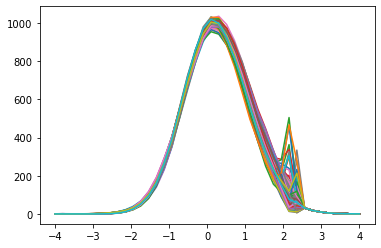

In [54]:
for bi in range(0, n_boot_samples) :
    plt.plot( x, predictions[bi])
    
plt.show()

In [55]:
predictions.shape

(100, 40)

In [56]:
mean = np.mean( predictions, axis=0 )

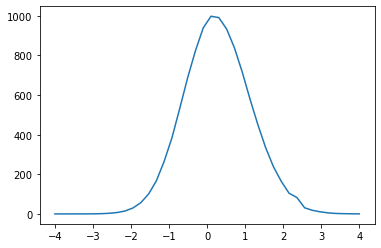

In [57]:
plt.plot(x,mean)

In [58]:
err = np.std( predictions, axis=0)

In [59]:
len(predictions[10])

40

In [60]:
predictions_swap = np.swapaxes(predictions,0,1)

In [61]:
predictions.shape

(100, 40)

In [62]:
predictions_swap.shape

(40, 100)

In [63]:
predictions[0]

array([3.50336673e-08, 5.42509922e-06, 1.13992030e-05, 9.81373242e-04,
       9.67303327e-03, 9.74799988e-02, 4.72656445e-01, 2.14858374e+00,
       6.65794977e+00, 1.60816127e+01, 3.30652793e+01, 6.13549352e+01,
       1.02616403e+02, 1.65863891e+02, 2.60694300e+02, 3.80311667e+02,
       5.36799481e+02, 7.03079165e+02, 8.51024254e+02, 9.66701052e+02,
       1.01347947e+03, 9.88430269e+02, 9.10593577e+02, 8.06088538e+02,
       6.83322000e+02, 5.49031300e+02, 4.27525571e+02, 3.19608717e+02,
       2.29104802e+02, 1.42353411e+02, 3.48549797e+01, 6.84786227e+01,
       3.08500000e+01, 1.81600000e+01, 1.06000000e+01, 5.30000000e+00,
       2.28000000e+00, 1.26000000e+00, 6.50000000e-01, 2.60000000e-01])

In [64]:
predictions_swap[20]

array([1013.47946738,  983.52749706,  998.04401506, 1009.72618105,
       1004.62366787, 1008.33586351, 1024.96210536,  995.53661091,
        979.22327232,  978.65237974,  979.64329628,  964.60956131,
        973.0671627 ,  972.53613466, 1006.07558881,  996.54940773,
       1007.92109555, 1031.58049915, 1003.26621652,  988.96991654,
       1015.35785224, 1020.80887617, 1022.97741921,  983.35175887,
        995.93239621,  990.99557052,  985.80311903,  995.97474029,
       1017.05555431, 1030.78102605,  989.31695639,  981.26725307,
        987.27271758,  989.82361869, 1014.45832594,  983.12566584,
        967.32301918, 1014.48541749,  987.53843726,  969.56664079,
        976.61235349, 1014.90854941, 1000.66219295, 1012.8788465 ,
       1004.94824157, 1009.84544257, 1012.13751304,  999.04042436,
       1019.62913787,  995.79341573, 1006.16925931, 1030.68215824,
        998.64861044,  983.43844697,  988.74227005,  994.60586962,
       1014.94459638, 1024.24201033, 1003.73750673,  989.76608

In [65]:
cov = np.cov( predictions_swap )

In [66]:
cov.shape

(40, 40)

In [67]:
cov[20,20]

296.95144627520426

In [68]:
err[20]

17.145901312338534

In [69]:
np.sqrt(cov[20,20])

17.232279195602775

In [70]:
err[15]

11.882315727237794

In [71]:
np.sqrt(cov[15,15])

11.942176638723248

In [72]:
np.min(cov)

-565.0214892770193

In [73]:
np.max(cov)

10567.462778495723

In [74]:
np.min(V)

-22.797637405520526

In [75]:
np.max(V)

165.97981626656158

In [76]:
for i in range(0,n_hist_bins) :
    for j in range(0, n_hist_bins) :
        #if np.abs(V[i,j]) > 40 :
        if i == j :
            print("  %3d, %3d : x = (%5.2f,%5.2f)  IBU V = %9.2f   bootstrap/toys = %9.2f |  %9.2f, %9.2f, %9.2f" % (i, j, x[i], x[j], V[i,j], cov[i,j], np.sqrt(V[i,j]), np.sqrt(cov[i,j]), err[i]))
            

    0,   0 : x = (-4.00,-4.00)  IBU V =      0.00   bootstrap/toys =      0.01 |       0.00,      0.11,      0.11
    1,   1 : x = (-3.79,-3.79)  IBU V =      0.00   bootstrap/toys =      0.05 |       0.00,      0.23,      0.22
    2,   2 : x = (-3.59,-3.59)  IBU V =      0.00   bootstrap/toys =      0.01 |       0.00,      0.12,      0.11
    3,   3 : x = (-3.38,-3.38)  IBU V =      0.00   bootstrap/toys =      0.02 |       0.00,      0.14,      0.14
    4,   4 : x = (-3.18,-3.18)  IBU V =      0.00   bootstrap/toys =      0.04 |       0.01,      0.20,      0.20
    5,   5 : x = (-2.97,-2.97)  IBU V =      0.00   bootstrap/toys =      0.12 |       0.03,      0.35,      0.35
    6,   6 : x = (-2.77,-2.77)  IBU V =      0.02   bootstrap/toys =      0.33 |       0.13,      0.58,      0.57
    7,   7 : x = (-2.56,-2.56)  IBU V =      0.11   bootstrap/toys =      0.96 |       0.33,      0.98,      0.98
    8,   8 : x = (-2.36,-2.36)  IBU V =      0.38   bootstrap/toys =      2.44 |       0

In [77]:
bs_correlation_matrix = np.zeros( shape=cov.shape )

for i in range(0, n_hist_bins) :
    sigma_i = np.sqrt( cov[i,i] )
    for j in range(0, n_hist_bins) :
        sigma_j = np.sqrt( cov[j,j] )
        rho = 0
        if sigma_i > 0 and sigma_j > 0 :
            rho = cov[i,j] / (sigma_i * sigma_j)
        bs_correlation_matrix[i,j] = rho
        


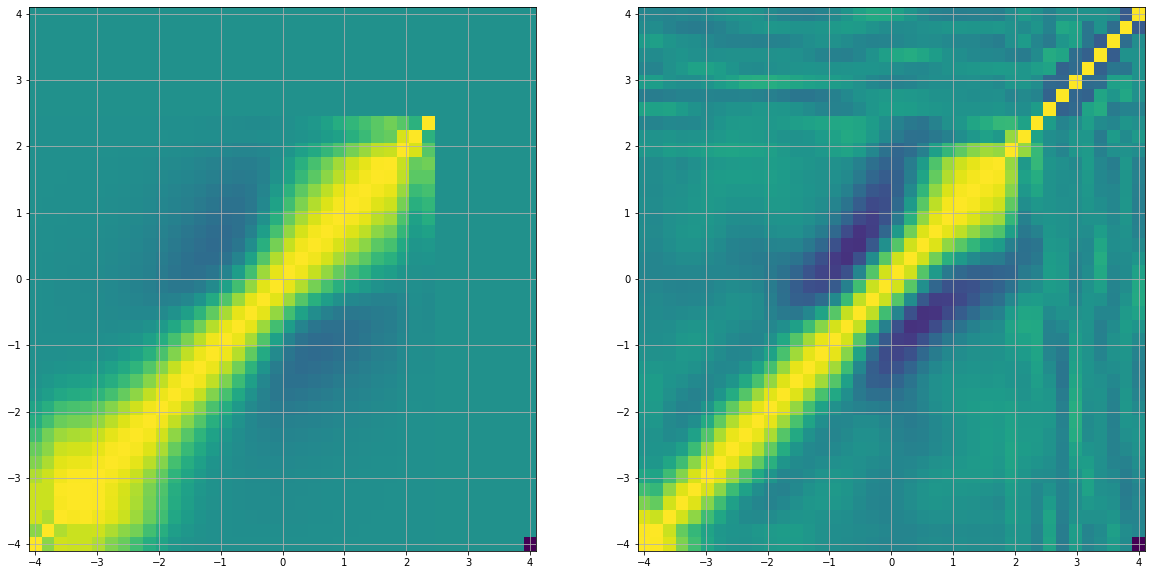

In [78]:
fig,ax = plt.subplots(1,2,figsize=(20,10))

bs_correlation_matrix[0,39] = -1.
correlation_matrix[0,39] = -1.

ax[0].pcolormesh( x_bins, x_bins, correlation_matrix )
ax[0].grid(True)

ax[1].pcolormesh( x_bins, x_bins, bs_correlation_matrix )
ax[1].grid(True)

plt.show()

In [79]:
np.min(correlation_matrix)

-1.0

In [80]:
np.min(bs_correlation_matrix)

-1.0

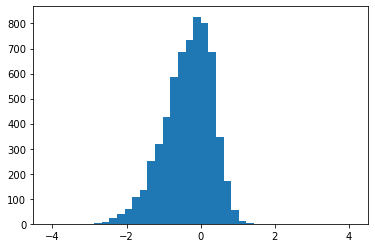

In [81]:
nat_hist_data = plt.hist(toy_nat_acc, bins=x_bins)
sqrtn_err = np.sqrt(nat_hist_data[0])

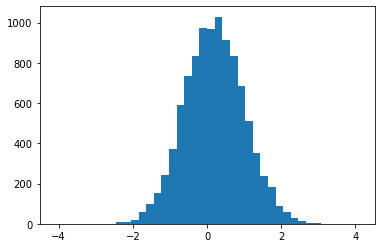

In [82]:
nat0_hist_data = plt.hist(toy_nat0, bins=x_bins)
sqrtn0_err = np.sqrt(nat0_hist_data[0])

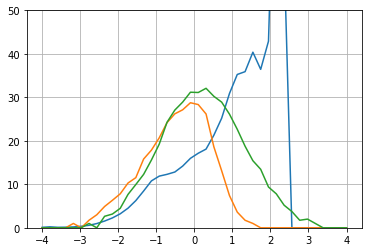

In [83]:
plt.plot( x, err)
plt.plot( x, sqrtn_err)
plt.plot( x, sqrtn0_err)
plt.grid(True)
ax = plt.gca()
ax.set_ylim([0,50])
plt.show()

<ErrorbarContainer object of 3 artists>

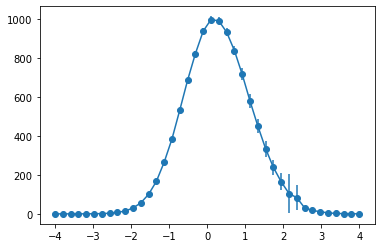

In [84]:
plt.errorbar( x, mean, yerr=err, fmt='-o')

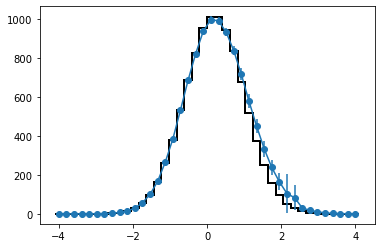

In [85]:
hist_data_nat0 = plt.hist( toy_nat0_100x, bins=x_bins, weights=weights_nat0_100x,
                      linewidth=2, density=False, color='black', histtype = 'step')
plot_data = plt.errorbar( x, mean, yerr=err, fmt='-o')

plt.show()

In [86]:
diff = mean - hist_data_nat0[0]

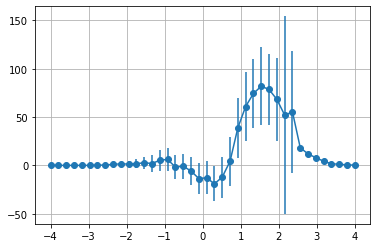

In [87]:
plot_data = plt.errorbar( x, diff, yerr=err, fmt='-o')
plt.grid()
plt.show()

In [88]:
diff2 = prediction[0] - hist_data_nat0[0]

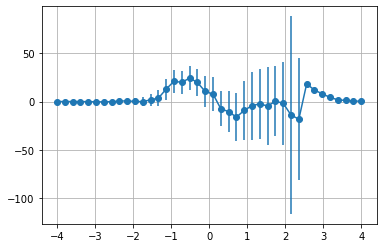

In [89]:
plot_data = plt.errorbar( x, diff2, yerr=err, fmt='-o')
plt.grid()
plt.show()

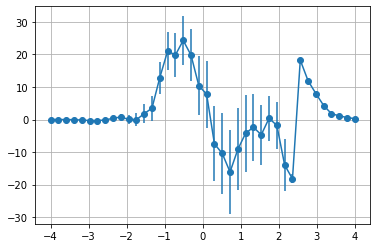

In [90]:
plot_data = plt.errorbar( x, diff2, yerr=pred_errs, fmt='-o')
plt.grid()
plt.show()

In [91]:

for j in range(0,n_hist_bins):

    ratio = 0
    if pred_errs[j] > 0 : ratio = err[j]/pred_errs[j]
    print("  bin %3d : x = %5.2f,  N =  %9.1f +/-  bootstrap err  %9.1f,  IBU error %9.1f,  ratio %5.2f" 
          % (j, x[j],  prediction[0][j], err[j], pred_errs[j],  ratio) )
    

  bin   0 : x = -4.00,  N =        0.0 +/-  bootstrap err        0.1,  IBU error       0.0,  ratio 194669.49
  bin   1 : x = -3.79,  N =        0.0 +/-  bootstrap err        0.2,  IBU error       0.0,  ratio 499114.59
  bin   2 : x = -3.59,  N =        0.0 +/-  bootstrap err        0.1,  IBU error       0.0,  ratio 4662.98
  bin   3 : x = -3.38,  N =        0.0 +/-  bootstrap err        0.1,  IBU error       0.0,  ratio 223.54
  bin   4 : x = -3.18,  N =        0.0 +/-  bootstrap err        0.2,  IBU error       0.0,  ratio 38.63
  bin   5 : x = -2.97,  N =        0.2 +/-  bootstrap err        0.3,  IBU error       0.0,  ratio 10.00
  bin   6 : x = -2.77,  N =        0.9 +/-  bootstrap err        0.6,  IBU error       0.1,  ratio  4.48
  bin   7 : x = -2.56,  N =        2.7 +/-  bootstrap err        1.0,  IBU error       0.3,  ratio  3.00
  bin   8 : x = -2.36,  N =        6.5 +/-  bootstrap err        1.6,  IBU error       0.6,  ratio  2.51
  bin   9 : x = -2.15,  N =       14.1 +/-  

In [92]:
predictions.shape

(100, 40)

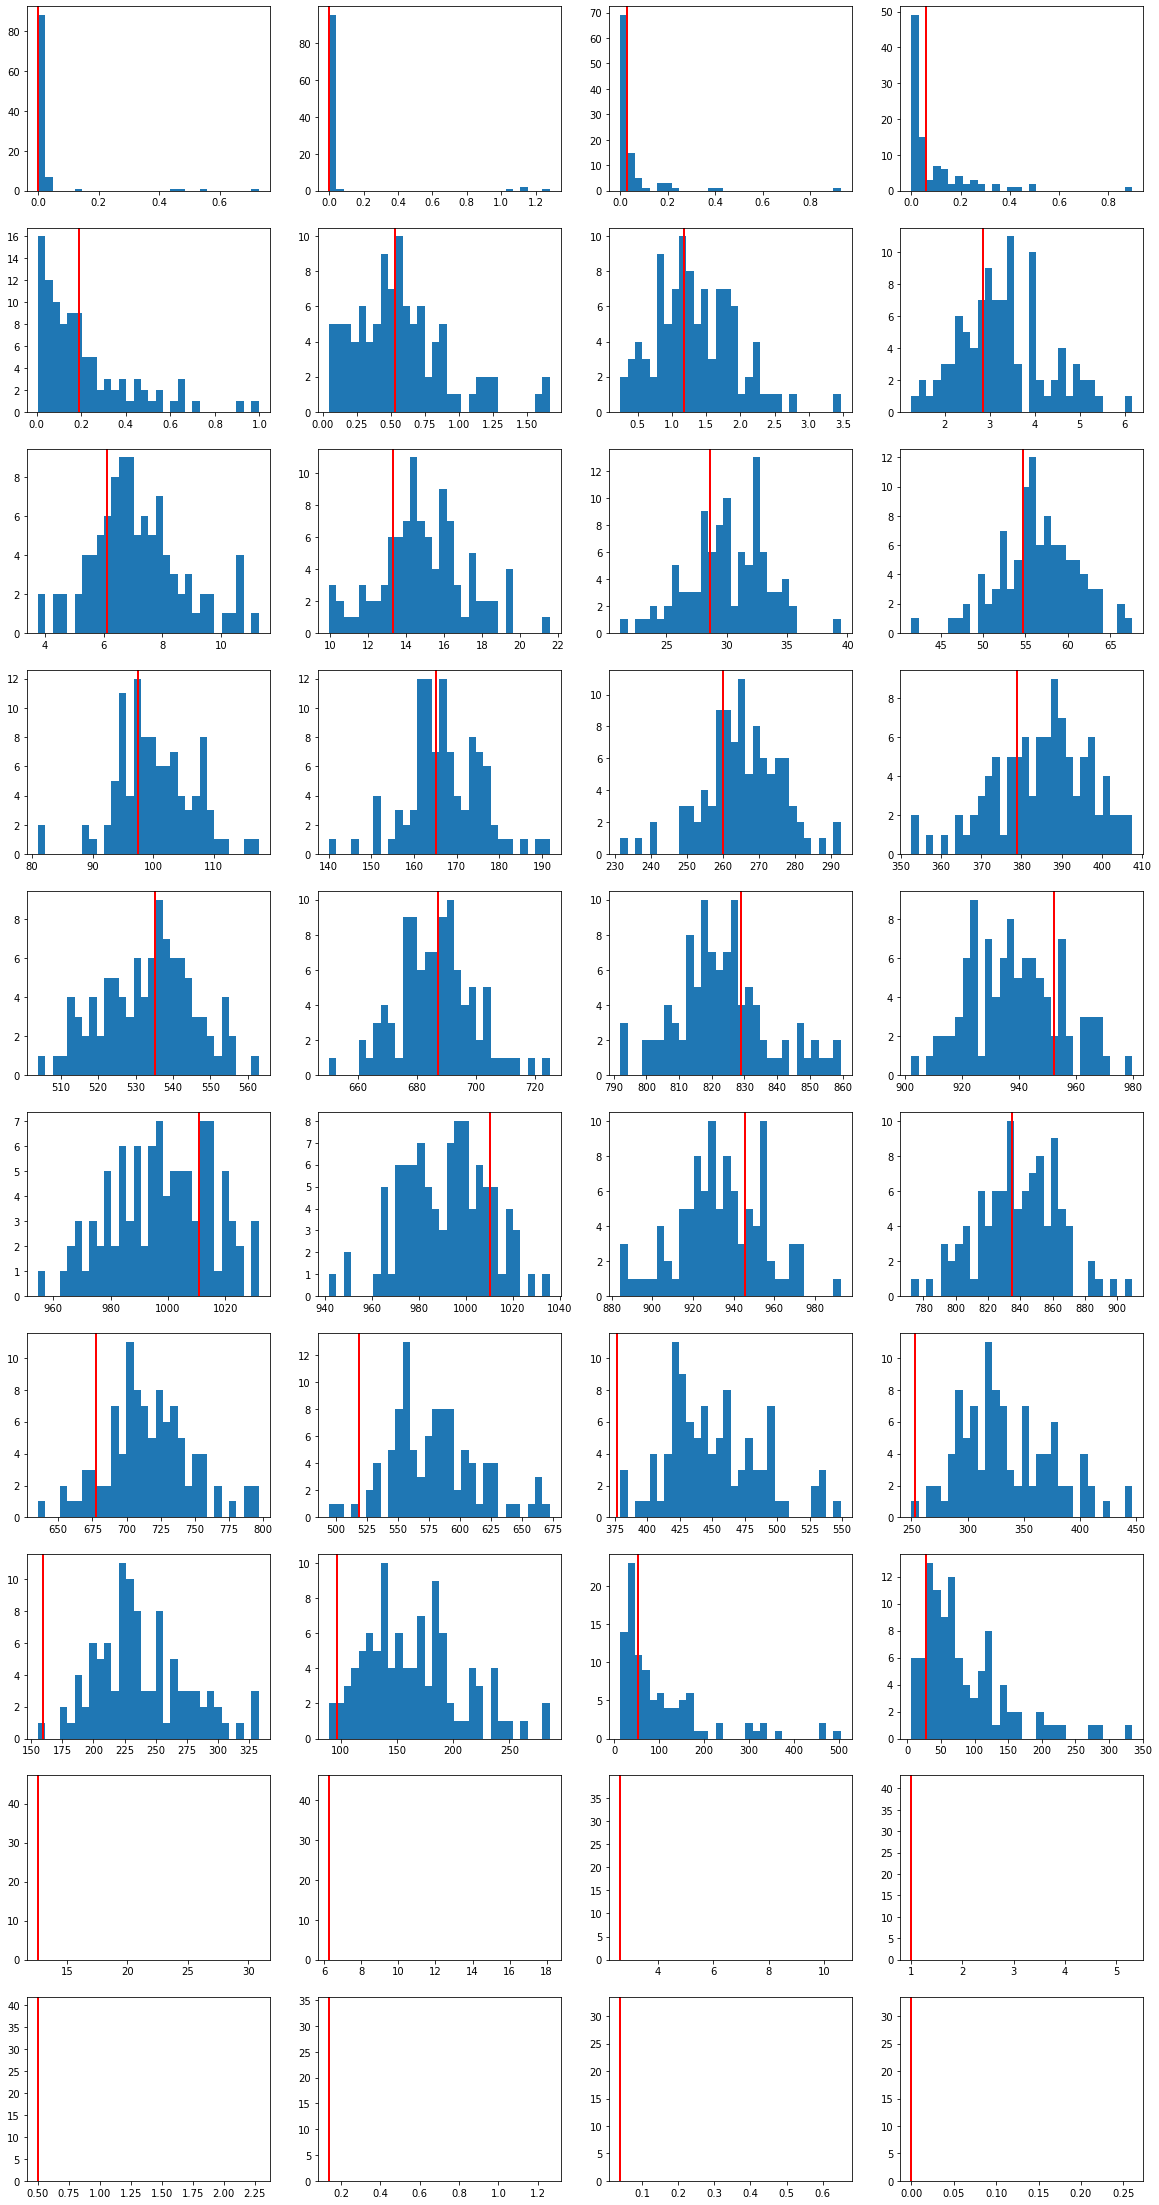

In [93]:
fig,ax = plt.subplots(10,4,figsize=(20,40))

ax_flat = ax.flatten()

for bini in range(0, len(predictions[1]) ) :
    ax_flat[bini].hist( predictions[:,bini], bins=30)
    ax_flat[bini].axvline( hist_data_nat0[0][bini], color='red', lw=2)
    
plt.show()
    